<a href="https://colab.research.google.com/github/BrainConnection/Dynamical_Decoupling_Project/blob/main/4.%20Measurement%20Induced%20Dephasing%20Practice.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Environment Setting

In [1]:
!pip install qutip
!pip install numpy
!pip install matplotlib
!pip install scipy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.3/16.3 MB 57.5 MB/s eta 0:00:00


In [2]:
from qutip import *
import numpy as np
import matplotlib.pyplot as plt
import scipy.interpolate
from scipy.optimize import curve_fit
from numpy.random import uniform

/usr/local/lib/python3.10/dist-packages/qutip/__init__.py:66: UserWarning: The new version of Cython, (>= 3.0.0) is not supported.
  warnings.warn(


# 9. Measurement Induced Dephasing

###1) Hamiltonian & Function Setting

Lab Frame

$H_0 = -\frac{\omega_q}{2}\sigma_z + \omega_r a^\dagger a + g\sigma_x(a+a^\dagger)$

$H_1 = A(t) (\hat{a} + \hat{a}^\dagger) \cos{(\omega_{rd} t)}$

$H_2 = B(t) \sigma_x \cos{(\omega_{qd} t)}$

Rotating Frame

$H_0 = -\frac{\omega_q-\omega_{qd}}{2}\sigma_z + ({\omega_r-\omega_{rd}})a^\dagger a + \chi\sigma_z(a^\dagger a)$

$H_1 = \frac{A(t)}{2} (\hat{a} + \hat{a}^\dagger) $

$H_2 = \frac{B(t)}{2}  \sigma_x $

In [17]:
# operator
N = 100

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 7.0  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

In [18]:
sz = sigmaz()
sx = sigmax()
sy = sigmay()

sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()

a = destroy(N)

In [19]:
sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [20]:
H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())

H1 = 0.5*tensor(qeye(2), a + a.dag())

H2_x = 0.5*sx_composite

In [21]:
# single pi & half pi square pulse for drive

def Pi_Square(t, args, T_cent):

    A = args['A']

    return A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

def Half_Pi_Square(t, args, T_cent):

    A = args['A']

    return 0.5 * A * (t > T_cent-0.5*np.pi/A) * (t < T_cent+0.5*np.pi/A)

In [22]:
# time-dependent envelope for drive

def Hrd_env(Env, Is_Pi):

  if (Env==0 and Is_Pi==0):
    return Half_Pi_Square

  elif (Env==0 and Is_Pi==1):
    return Pi_Square

# time-dependent function for drive

def Hrd_rot(f, t, args, T_cent):

    Omega_rd = args['Omega_rd']
    Phi = args['Phi']

    return f(t, args, T_cent) * np.cos(Omega_rd * t + Phi)

In [23]:
# Modulate each pulse timing
# pulse list
# pi/2 pulse at T_srt, T_end
# pi pulse at pulse time list

def Pulse_Timing(T_srt, T_end, N, Func):

    T = T_end - T_srt

    Seq_list = []

    if (Func==2) :
      shift = 0
      for i in range(N):
        shift = shift + T * np.sin(np.pi/(2*(N+2))) * np.sin(np.pi*(i+1)/(N+2)) / np.cos(np.pi/(2*(N+2)))
        Seq_list.append(T_srt + shift)

    else :
      for i in range(N):
        Seq_list.append(T_srt + (2*i+1)*T/(2*N))

    Seq = np.array(Seq_list)

    return Seq

In [24]:
# time-dependent envelope for qubit drive (rotating frame)

# args

# A (amplitude)
# Omega_rd (frequency)
# T_srt (pulse start time)
# T_end (pulse end time)
# N (number of pulse)
# Env (0: square envelope, 1: cosine envelope, 2: gaussian envelope)
# Func (0: CP, 1: CPMG, 2: UDD)

def Hqd_rotating_frame(t, args):

    T_srt = args['T_srt']
    T_end = args['T_end']
    N = args['N_seq']
    Env = args['Env']
    Func = args['Func']

    B = args['B']


    # T_cent
    Seq = Pulse_Timing(T_srt, T_end, N, Func)


    f = Hrd_env(Env, 0)
    pulse = f(t, {'A': B}, T_srt)

    for T_cent in Seq:
      f = Hrd_env(Env, 1)
      pulse = pulse + f(t, {'A': B}, T_cent)

    f = Hrd_env(Env, 0)
    pulse = pulse + f(t, {'A': B}, T_end)

    return pulse

In [25]:
# time-dependent coefficient for resonator drive

def Hrd_rotating_frame(t, args):
    """
    Envelope function for the readout drive
    """
    A = args['A'] # amplitude of the readout drive
    T = args['T'] # duration of the readout drive, in units of ns

    return A * (0 <= t) * (t <= T)

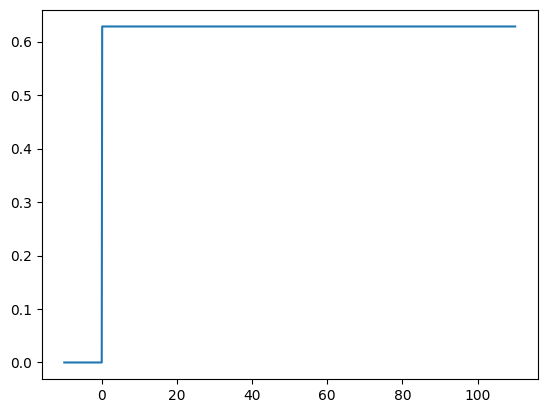

In [26]:
# resonator pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hrd_rotating_frame(tlist, {'A': 2*np.pi*0.1, 'T': 150}))

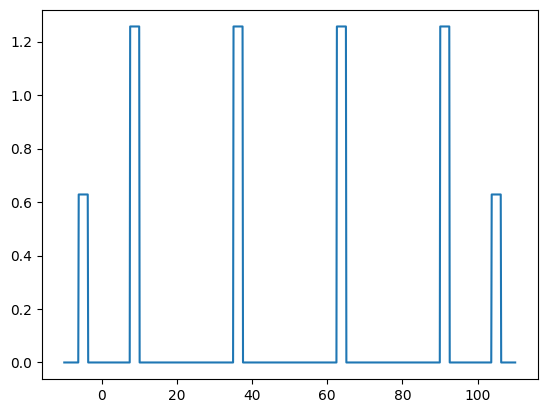

In [27]:
# qubit pulse simulation (rotating frame)
tlist = np.linspace(-10, 110, 1000)
plt.figure()
plt.plot(tlist, Hqd_rotating_frame(tlist, {'B': 2*np.pi*0.2, 'T_srt': -5, 'T_end': 105, 'N_seq': 4, 'Env': 0, 'Func': 0}))

### 2) Determine Drive Amplitude & Detune (Ramsey, Rotating Frame)

Driving Amplitude $A=1GHz$, $A=0.1GHz$, $A=0.01GHz$

Driving Frequency $\omega_{rd}=6.99GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [ ]:
# operator
N = 60

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
sm = basis(2,0)*basis(2,1).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
sm_composite = tensor(sm, qeye(N))

annihilate_composite = tensor(qeye(2), a)
create_composite = tensor(qeye(2), a.dag())
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, sm_composite, annihilate_composite, create_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

In [ ]:
omega_r = 2 * np.pi * 7.0     # resonator frequency in units of GHz
omega_q = 2 * np.pi * 5.5     # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.99   # qubit frequency in units of GHz
g = 2 * np.pi * 0.1           # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01      # external coupling rate of resonator in units of GHz

H0 = -0.5*(omega_q-omega_rd)*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sx, a + a.dag())
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2_x = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

result3 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result4 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.1, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result5 = mesolve(
    [H0, [H1, Hrd_res_env], [H2_x, Hrd_qubit_rotating_frame_x]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'A': 2*np.pi*0.2, 'Omega_rd': omega_rd, 'T_srt': -2.5, 'T_end': 1002.5, 'N': 0, 'Env': 0, 'Func': 0, 'A_res': 2 * np.pi * 0.01, 'T_res': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

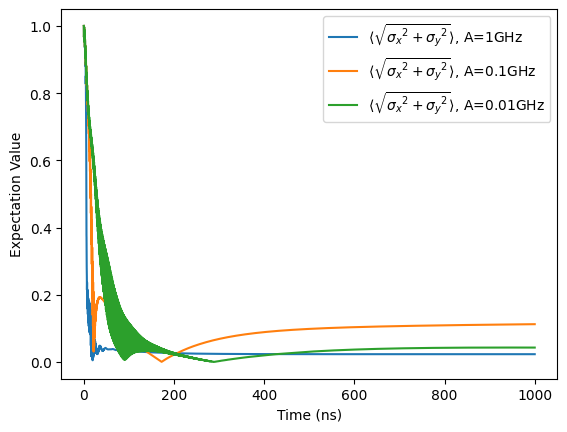

In [ ]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result3.expect[0])**2 + (result3.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=1GHz')
ax.plot(tlist, np.sqrt((result4.expect[0])**2 + (result4.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz')
ax.plot(tlist, np.sqrt((result5.expect[0])**2 + (result5.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

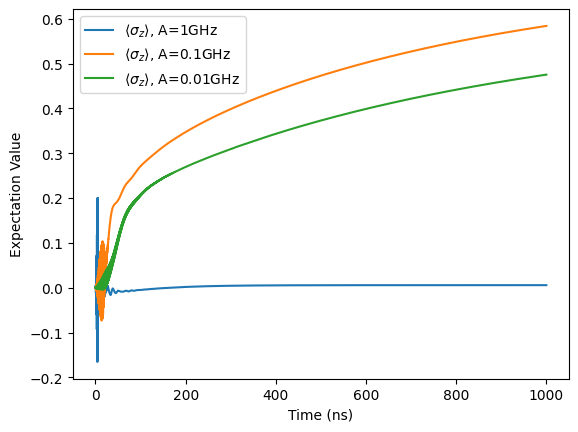

In [ ]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result3.expect[2], label = r'$\langle\sigma_z\rangle$, A=1GHz')
ax.plot(tlist, result4.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz')
ax.plot(tlist, result5.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

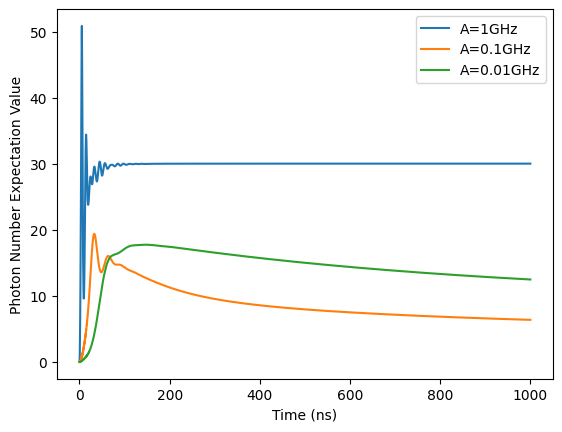

In [ ]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result3.expect[7], label = 'A=1GHz')
ax.plot(tlist, result4.expect[7], label = 'A=0.1GHz')
ax.plot(tlist, result5.expect[7], label = 'A=0.01GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

### 3) Determine Drive Amplitude & Detune (Ramsey, Rotating Frame)

Driving Amplitude

Driving Frequency $\omega_{rd}=6.9GHz$

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$


In [52]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

In [53]:
result = mesolve(
  [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
  psi_2s,
  tlist,
  c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
  args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 50*20+20, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.1, 'T': 1500},
  e_ops = op_list,
  options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result1 = mesolve(
  [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
  psi_2s,
  tlist,
  c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
  args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 50*20+20, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.01, 'T': 1500},
  e_ops = op_list,
  options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

result2 = mesolve(
  [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
  psi_2s,
  tlist,
  c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
  args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 50*20+20, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.005, 'T': 1500},
  e_ops = op_list,
  options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
)

Text(0, 0.5, 'Expectation Value')

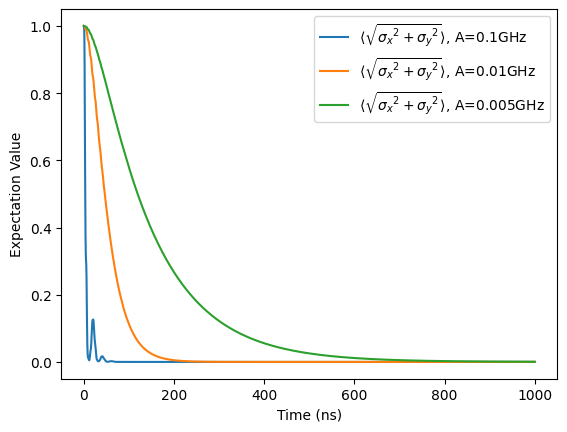

In [54]:
# Plot sqrt(X**2+Y**2)

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, np.sqrt((result.expect[0])**2 + (result.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.1GHz')
ax.plot(tlist, np.sqrt((result1.expect[0])**2 + (result1.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.01GHz')
ax.plot(tlist, np.sqrt((result2.expect[0])**2 + (result2.expect[1])**2), label = r'$\langle\sqrt{{\sigma_x}^2+{\sigma_y}^2}\rangle$, A=0.005GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Expectation Value')

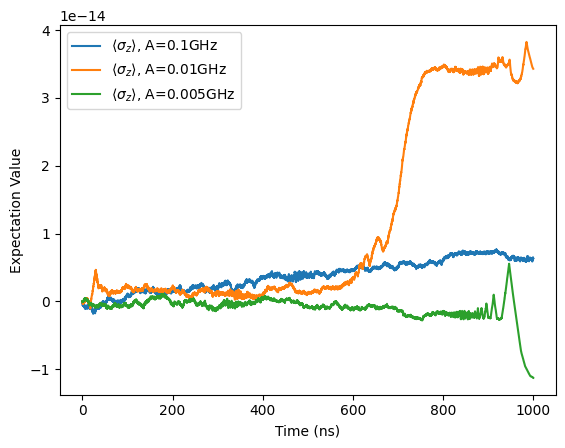

In [55]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.1GHz')
ax.plot(tlist, result1.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.01GHz')
ax.plot(tlist, result2.expect[2], label = r'$\langle\sigma_z\rangle$, A=0.005GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Photon Number Expectation Value')

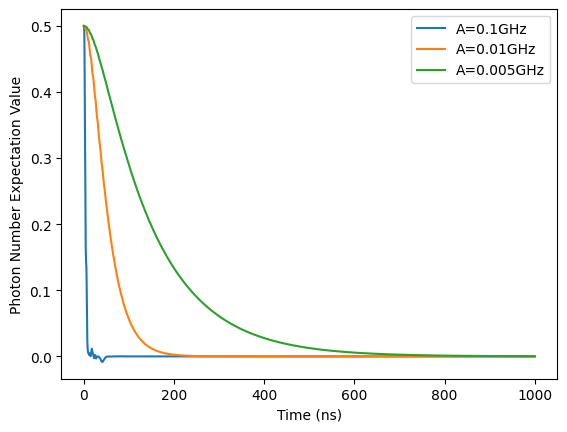

In [56]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[3], label = 'A=0.1GHz')
ax.plot(tlist, result1.expect[3], label = 'A=0.01GHz')
ax.plot(tlist, result2.expect[3], label = 'A=0.005GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

0.12507807619241507

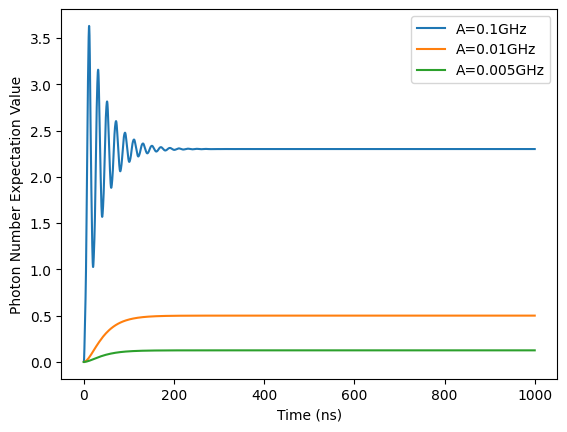

In [58]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[4], label = 'A=0.1GHz')
ax.plot(tlist, result1.expect[4], label = 'A=0.01GHz')
ax.plot(tlist, result2.expect[4], label = 'A=0.004GHz')
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

n = result2.expect[4]
n[-1]

### 4) Photon Number n

kappa = 2 * np.pi * 0.01

In [73]:
A = [0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014, 0.015]

In [74]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

In [75]:
plus_list = []
n_list = []
for i in range(13):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 50*20+20, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(result.expect[3])
  n_list.append(result.expect[4])

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Off Diagonal Term Expectation Value')

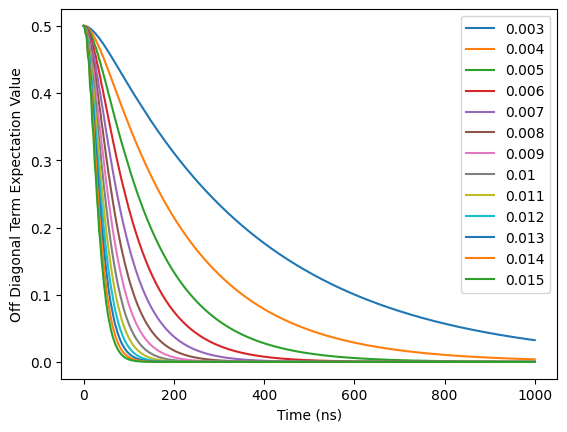

In [76]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(13):
  ax.plot(tlist, plus_list[i], label = '{0}'.format(A[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

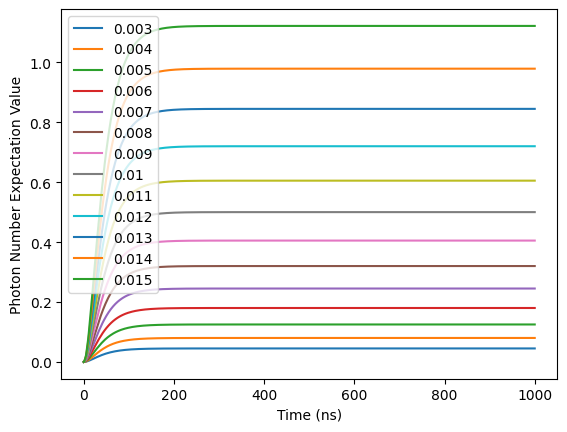

In [77]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(13):
  ax.plot(tlist, n_list[i], label = '{0}'.format(A[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [79]:
for i in range(13):
  print(n_list[i][-1])

0.045028107432850496
0.08004996876938565
0.12507807619241507
0.18011242939406957
0.24515302299067046
0.3201997973303341
0.40525228964057836
0.5003078087421398
0.605354044381453
0.7203451420457617
0.8451385011897605
0.9793573413779474
1.122146179166286


### 5) Off Diagonal Term Evolution B=0.05GHz without Brain

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

Result :


In [87]:
A =     [0.005, 0.006, 0.007, 0.008, 0.009, 0.01, 0.011, 0.012, 0.013, 0.014]
n_exp = [0.125, 0.180, 0.245, 0.320, 0.405, 0.500, 0.605, 0.720, 0.845, 0.979]
N_seq = [0,1,2,4,6,8]
tau_list = [50*(k+2) for k in range(19)]

#### A = 0.005

In [91]:
z_tot_1 = []
plus_tot_1 = []

In [92]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [93]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.005, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_1.append(z)
  plus_tot_1.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

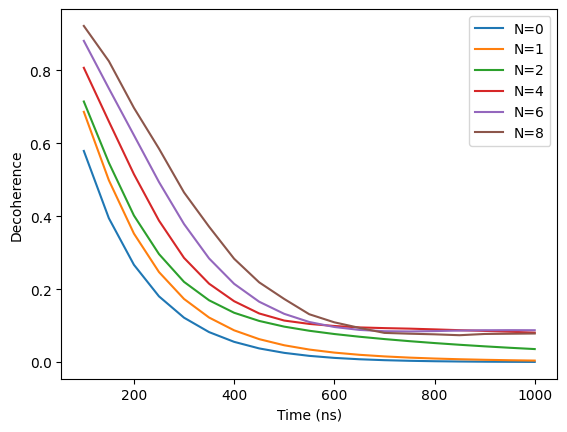

In [94]:
plt.plot(tau_list, plus_tot_1[0], label = 'N=0')
plt.plot(tau_list, plus_tot_1[1], label = 'N=1')
plt.plot(tau_list, plus_tot_1[2], label = 'N=2')
plt.plot(tau_list, plus_tot_1[3], label = 'N=4')
plt.plot(tau_list, plus_tot_1[4], label = 'N=6')
plt.plot(tau_list, plus_tot_1[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

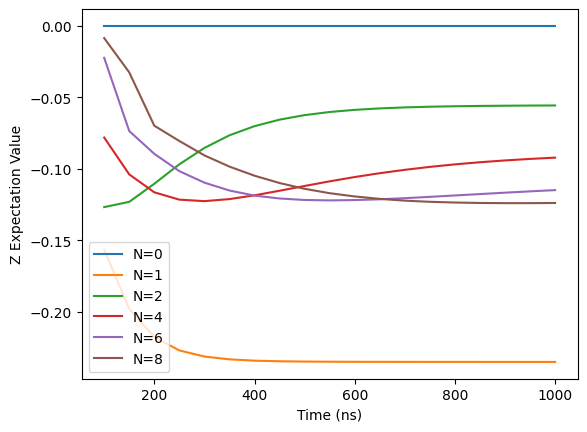

In [95]:
plt.plot(tau_list, z_tot_1[0], label = 'N=0')
plt.plot(tau_list, z_tot_1[1], label = 'N=1')
plt.plot(tau_list, z_tot_1[2], label = 'N=2')
plt.plot(tau_list, z_tot_1[3], label = 'N=4')
plt.plot(tau_list, z_tot_1[4], label = 'N=6')
plt.plot(tau_list, z_tot_1[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.006

In [99]:
z_tot_2 = []
plus_tot_2 = []

In [100]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [101]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.006, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_2.append(z)
  plus_tot_2.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

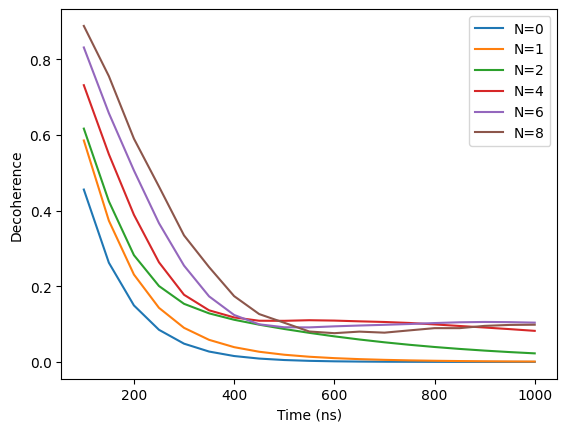

In [102]:
plt.plot(tau_list, plus_tot_2[0], label = 'N=0')
plt.plot(tau_list, plus_tot_2[1], label = 'N=1')
plt.plot(tau_list, plus_tot_2[2], label = 'N=2')
plt.plot(tau_list, plus_tot_2[3], label = 'N=4')
plt.plot(tau_list, plus_tot_2[4], label = 'N=6')
plt.plot(tau_list, plus_tot_2[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

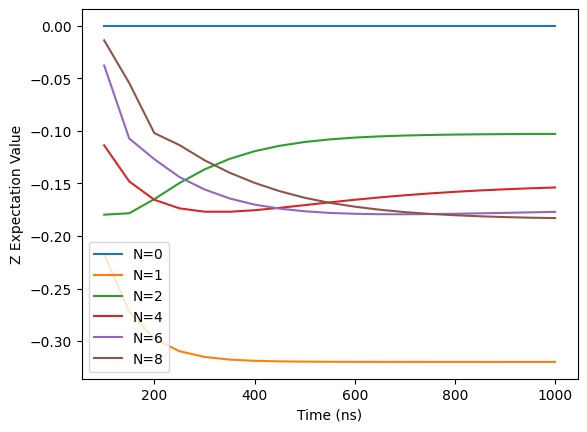

In [103]:
plt.plot(tau_list, z_tot_2[0], label = 'N=0')
plt.plot(tau_list, z_tot_2[1], label = 'N=1')
plt.plot(tau_list, z_tot_2[2], label = 'N=2')
plt.plot(tau_list, z_tot_2[3], label = 'N=4')
plt.plot(tau_list, z_tot_2[4], label = 'N=6')
plt.plot(tau_list, z_tot_2[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.007

In [104]:
z_tot_3 = []
plus_tot_3 = []

In [105]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [106]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.007, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_3.append(z)
  plus_tot_3.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

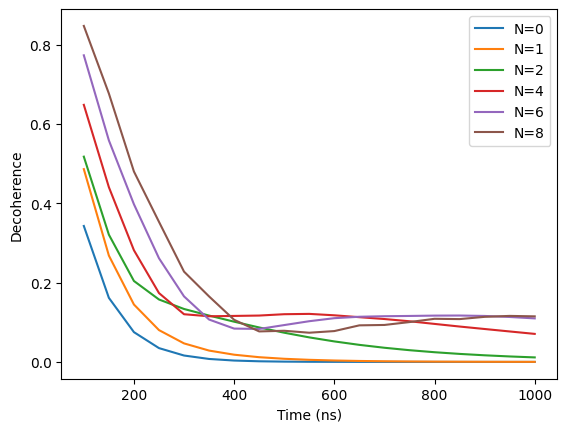

In [107]:
plt.plot(tau_list, plus_tot_3[0], label = 'N=0')
plt.plot(tau_list, plus_tot_3[1], label = 'N=1')
plt.plot(tau_list, plus_tot_3[2], label = 'N=2')
plt.plot(tau_list, plus_tot_3[3], label = 'N=4')
plt.plot(tau_list, plus_tot_3[4], label = 'N=6')
plt.plot(tau_list, plus_tot_3[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

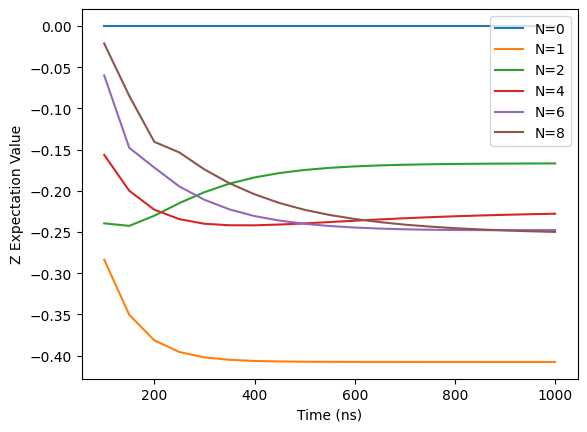

In [108]:
plt.plot(tau_list, z_tot_3[0], label = 'N=0')
plt.plot(tau_list, z_tot_3[1], label = 'N=1')
plt.plot(tau_list, z_tot_3[2], label = 'N=2')
plt.plot(tau_list, z_tot_3[3], label = 'N=4')
plt.plot(tau_list, z_tot_3[4], label = 'N=6')
plt.plot(tau_list, z_tot_3[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.008

In [109]:
z_tot_4 = []
plus_tot_4 = []

In [110]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [111]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.008, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_4.append(z)
  plus_tot_4.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

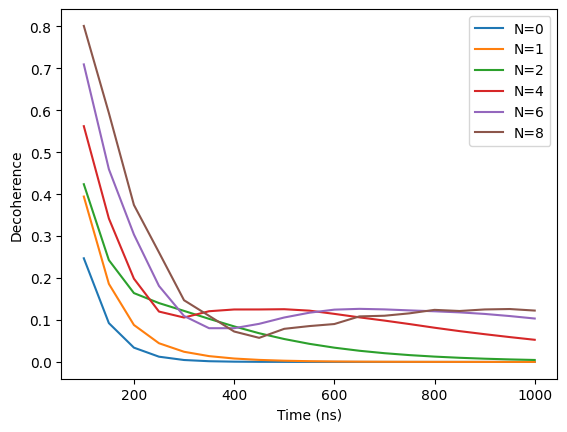

In [112]:
plt.plot(tau_list, plus_tot_4[0], label = 'N=0')
plt.plot(tau_list, plus_tot_4[1], label = 'N=1')
plt.plot(tau_list, plus_tot_4[2], label = 'N=2')
plt.plot(tau_list, plus_tot_4[3], label = 'N=4')
plt.plot(tau_list, plus_tot_4[4], label = 'N=6')
plt.plot(tau_list, plus_tot_4[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

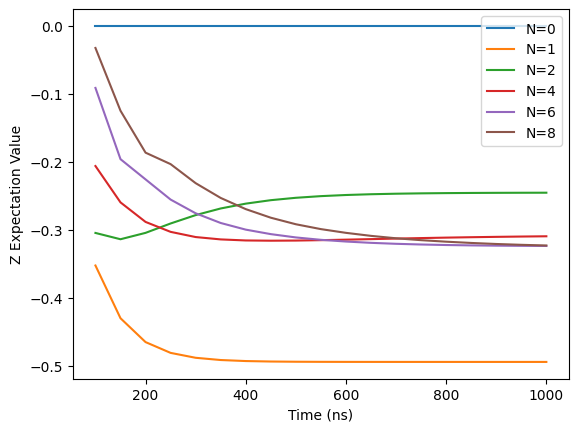

In [113]:
plt.plot(tau_list, z_tot_4[0], label = 'N=0')
plt.plot(tau_list, z_tot_4[1], label = 'N=1')
plt.plot(tau_list, z_tot_4[2], label = 'N=2')
plt.plot(tau_list, z_tot_4[3], label = 'N=4')
plt.plot(tau_list, z_tot_4[4], label = 'N=6')
plt.plot(tau_list, z_tot_4[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.009

In [114]:
z_tot_5 = []
plus_tot_5 = []

In [115]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [116]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.009, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_5.append(z)
  plus_tot_5.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

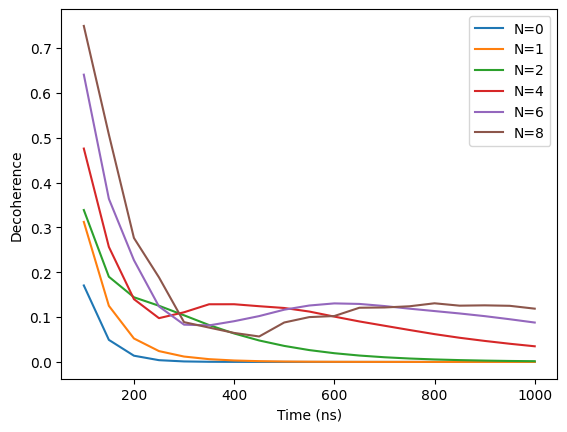

In [117]:
plt.plot(tau_list, plus_tot_5[0], label = 'N=0')
plt.plot(tau_list, plus_tot_5[1], label = 'N=1')
plt.plot(tau_list, plus_tot_5[2], label = 'N=2')
plt.plot(tau_list, plus_tot_5[3], label = 'N=4')
plt.plot(tau_list, plus_tot_5[4], label = 'N=6')
plt.plot(tau_list, plus_tot_5[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

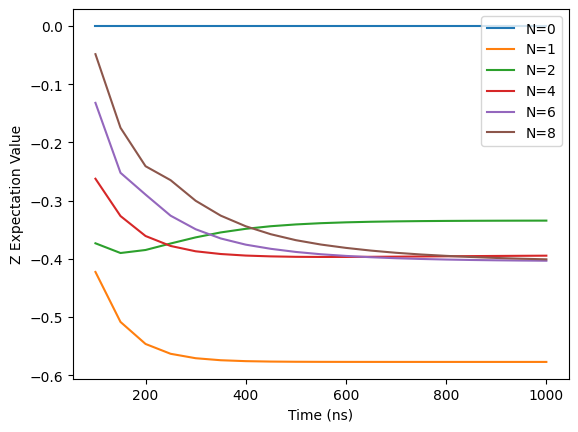

In [118]:
plt.plot(tau_list, z_tot_5[0], label = 'N=0')
plt.plot(tau_list, z_tot_5[1], label = 'N=1')
plt.plot(tau_list, z_tot_5[2], label = 'N=2')
plt.plot(tau_list, z_tot_5[3], label = 'N=4')
plt.plot(tau_list, z_tot_5[4], label = 'N=6')
plt.plot(tau_list, z_tot_5[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.010

In [119]:
z_tot_6 = []
plus_tot_6 = []

In [120]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [121]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.010, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_6.append(z)
  plus_tot_6.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

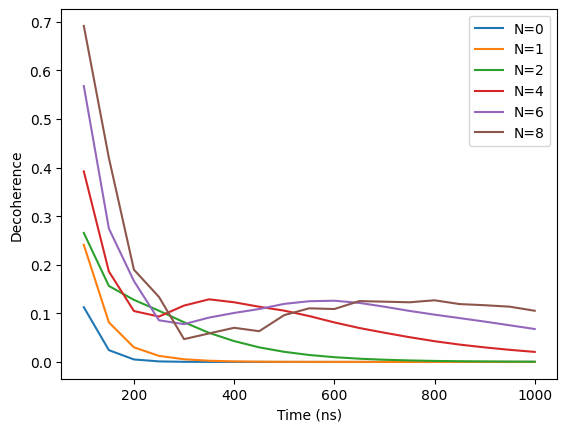

In [122]:
plt.plot(tau_list, plus_tot_6[0], label = 'N=0')
plt.plot(tau_list, plus_tot_6[1], label = 'N=1')
plt.plot(tau_list, plus_tot_6[2], label = 'N=2')
plt.plot(tau_list, plus_tot_6[3], label = 'N=4')
plt.plot(tau_list, plus_tot_6[4], label = 'N=6')
plt.plot(tau_list, plus_tot_6[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

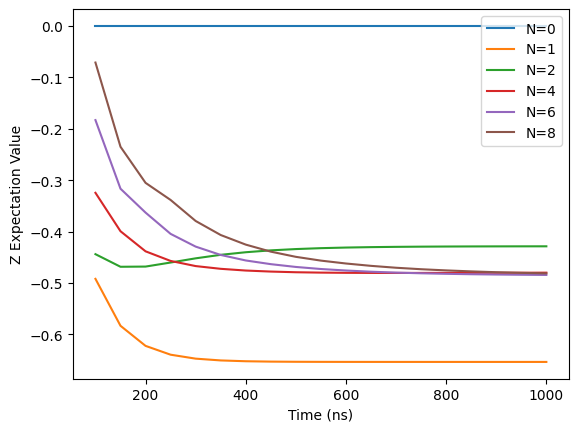

In [123]:
plt.plot(tau_list, z_tot_6[0], label = 'N=0')
plt.plot(tau_list, z_tot_6[1], label = 'N=1')
plt.plot(tau_list, z_tot_6[2], label = 'N=2')
plt.plot(tau_list, z_tot_6[3], label = 'N=4')
plt.plot(tau_list, z_tot_6[4], label = 'N=6')
plt.plot(tau_list, z_tot_6[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.011

In [124]:
z_tot_7 = []
plus_tot_7 = []

In [125]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [126]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.011, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_7.append(z)
  plus_tot_7.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

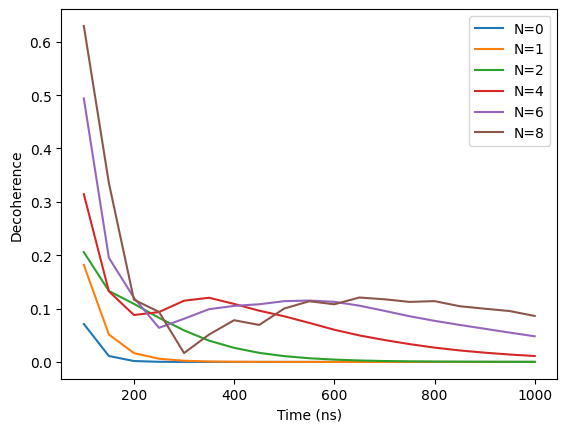

In [127]:
plt.plot(tau_list, plus_tot_7[0], label = 'N=0')
plt.plot(tau_list, plus_tot_7[1], label = 'N=1')
plt.plot(tau_list, plus_tot_7[2], label = 'N=2')
plt.plot(tau_list, plus_tot_7[3], label = 'N=4')
plt.plot(tau_list, plus_tot_7[4], label = 'N=6')
plt.plot(tau_list, plus_tot_7[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

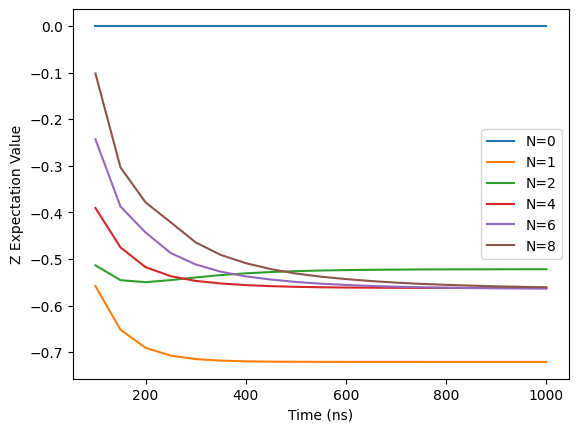

In [128]:
plt.plot(tau_list, z_tot_7[0], label = 'N=0')
plt.plot(tau_list, z_tot_7[1], label = 'N=1')
plt.plot(tau_list, z_tot_7[2], label = 'N=2')
plt.plot(tau_list, z_tot_7[3], label = 'N=4')
plt.plot(tau_list, z_tot_7[4], label = 'N=6')
plt.plot(tau_list, z_tot_7[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.012

In [129]:
z_tot_8 = []
plus_tot_8 = []

In [130]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [131]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.012, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_8.append(z)
  plus_tot_8.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

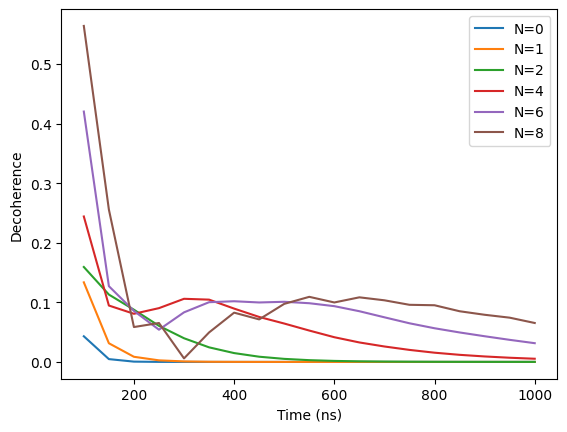

In [132]:
plt.plot(tau_list, plus_tot_8[0], label = 'N=0')
plt.plot(tau_list, plus_tot_8[1], label = 'N=1')
plt.plot(tau_list, plus_tot_8[2], label = 'N=2')
plt.plot(tau_list, plus_tot_8[3], label = 'N=4')
plt.plot(tau_list, plus_tot_8[4], label = 'N=6')
plt.plot(tau_list, plus_tot_8[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

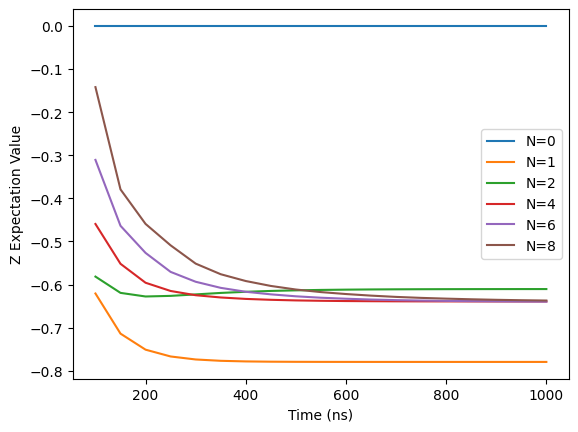

In [133]:
plt.plot(tau_list, z_tot_8[0], label = 'N=0')
plt.plot(tau_list, z_tot_8[1], label = 'N=1')
plt.plot(tau_list, z_tot_8[2], label = 'N=2')
plt.plot(tau_list, z_tot_8[3], label = 'N=4')
plt.plot(tau_list, z_tot_8[4], label = 'N=6')
plt.plot(tau_list, z_tot_8[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.013

In [134]:
z_tot_9 = []
plus_tot_9 = []

In [135]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [136]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.013, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_9.append(z)
  plus_tot_9.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

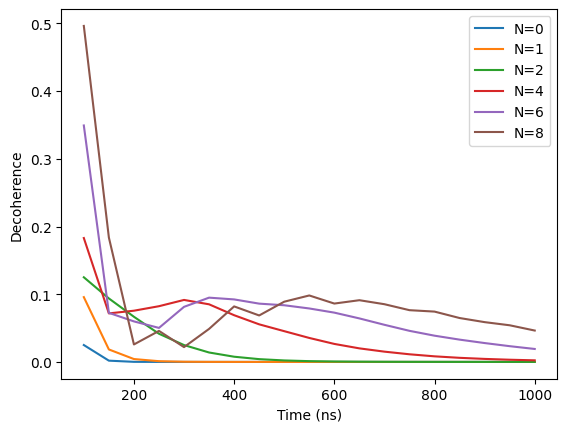

In [137]:
plt.plot(tau_list, plus_tot_9[0], label = 'N=0')
plt.plot(tau_list, plus_tot_9[1], label = 'N=1')
plt.plot(tau_list, plus_tot_9[2], label = 'N=2')
plt.plot(tau_list, plus_tot_9[3], label = 'N=4')
plt.plot(tau_list, plus_tot_9[4], label = 'N=6')
plt.plot(tau_list, plus_tot_9[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

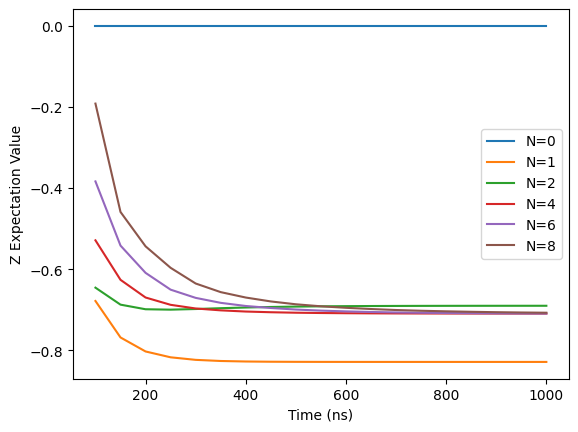

In [138]:
plt.plot(tau_list, z_tot_9[0], label = 'N=0')
plt.plot(tau_list, z_tot_9[1], label = 'N=1')
plt.plot(tau_list, z_tot_9[2], label = 'N=2')
plt.plot(tau_list, z_tot_9[3], label = 'N=4')
plt.plot(tau_list, z_tot_9[4], label = 'N=6')
plt.plot(tau_list, z_tot_9[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.014

In [139]:
z_tot_10 = []
plus_tot_10 = []

In [140]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [141]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*0.014, 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_10.append(z)
  plus_tot_10.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

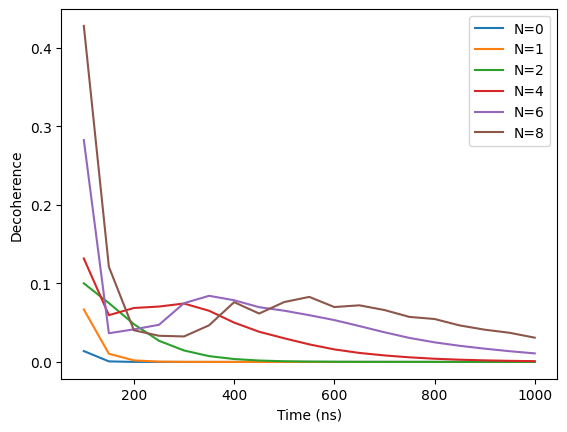

In [142]:
plt.plot(tau_list, plus_tot_10[0], label = 'N=0')
plt.plot(tau_list, plus_tot_10[1], label = 'N=1')
plt.plot(tau_list, plus_tot_10[2], label = 'N=2')
plt.plot(tau_list, plus_tot_10[3], label = 'N=4')
plt.plot(tau_list, plus_tot_10[4], label = 'N=6')
plt.plot(tau_list, plus_tot_10[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

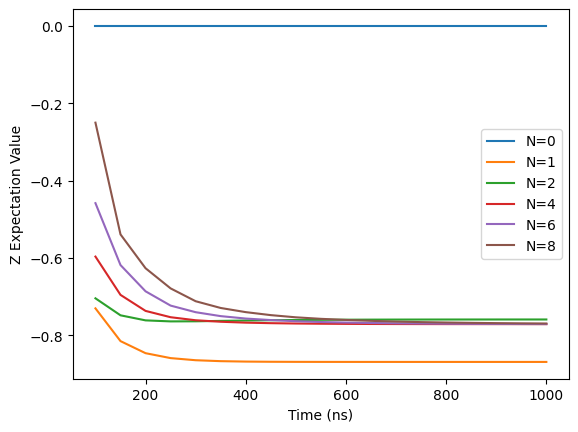

In [143]:
plt.plot(tau_list, z_tot_10[0], label = 'N=0')
plt.plot(tau_list, z_tot_10[1], label = 'N=1')
plt.plot(tau_list, z_tot_10[2], label = 'N=2')
plt.plot(tau_list, z_tot_10[3], label = 'N=4')
plt.plot(tau_list, z_tot_10[4], label = 'N=6')
plt.plot(tau_list, z_tot_10[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

### 6) Photon Number n

kappa = 2 * np.pi * 0.005

In [162]:
A = [0.002, 0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007, 0.0075]

In [163]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sx_composite, sy_composite, sz_composite, sp_composite, number_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

tlist = np.linspace(0, 1000, 10000)

In [164]:
plus_list = []
n_list = []
for i in range(12):
  result = mesolve(
    [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
    psi_2s,
    tlist,
    c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
    args = {'B': 2*np.pi*0.1, 'T_srt': -20, 'T_end': 50*20+20, 'N_seq': 0, 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[i], 'T': 1500},
    e_ops = op_list,
    options = Options(nsteps = 100000, atol = 1e-10, rtol = 1e-8)
  )

  plus_list.append(result.expect[3])
  n_list.append(result.expect[4])

/usr/local/lib/python3.10/dist-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


Text(0, 0.5, 'Off Diagonal Term Expectation Value')

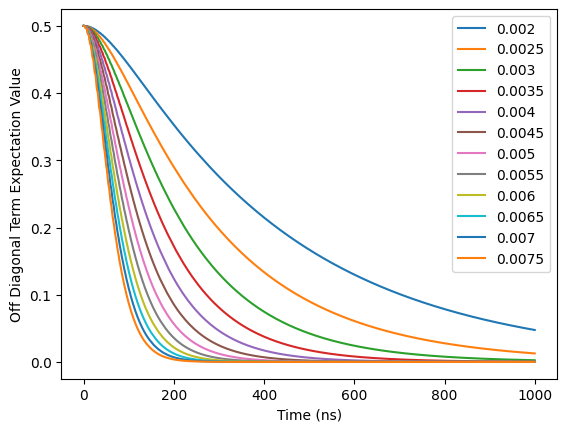

In [165]:
# Plot off-diagonal term expectation value

fig, ax = plt.subplots(1, 1)

for i in range(12):
  ax.plot(tlist, plus_list[i], label = '{0}'.format(A[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Off Diagonal Term Expectation Value')

Text(0, 0.5, 'Photon Number Expectation Value')

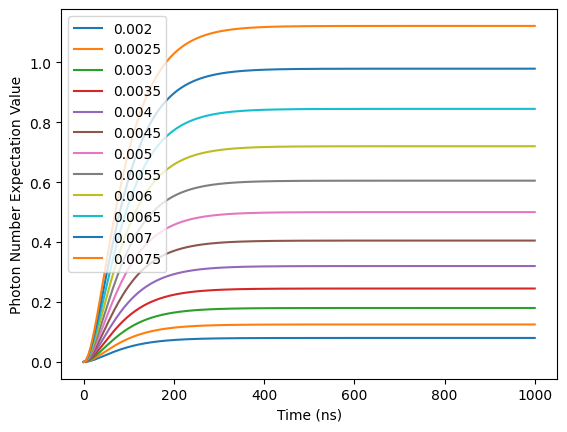

In [166]:
# Plot photon number expectation value

fig, ax = plt.subplots(1, 1)

for i in range(12):
  ax.plot(tlist, n_list[i], label = '{0}'.format(A[i]))

ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Photon Number Expectation Value')

In [167]:
for i in range(12):
  print(n_list[i][-1])

0.08001247393101024
0.12501949050745562
0.18002806600774898
0.24503819504854682
0.3200498179815506
0.4050624720612646
0.5000734662588254
0.6050704909717556
0.7200076939298884
0.8447424807380483
0.9788980838827249
1.1216190380063582


### 7) Off Diagonal Term Evolution B=0.05GHz with Brain

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

kappa = 0.005 GHz

Result :


In [271]:
A =     [0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007]
n_exp = [0.125, 0.180, 0.245, 0.320, 0.405, 0.500, 0.605, 0.720, 0.845, 0.978]
N_seq = [0,1,2,4,6,8]
tau_list = [50*(k+2) for k in range(19)]

#### A = 0.005

In [285]:
z_tot_1 = []
plus_tot_1 = []

In [286]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz
kai = 2 * np.pi * 0.01

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = +kai*n_exp[0]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [287]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[0], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_1.append(z)
  plus_tot_1.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

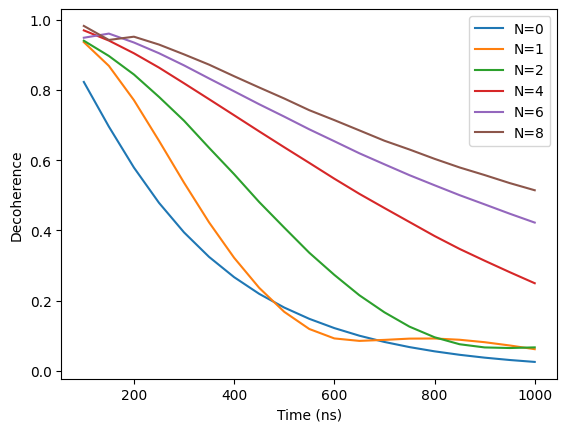

In [288]:
plt.plot(tau_list, plus_tot_1[0], label = 'N=0')
plt.plot(tau_list, plus_tot_1[1], label = 'N=1')
plt.plot(tau_list, plus_tot_1[2], label = 'N=2')
plt.plot(tau_list, plus_tot_1[3], label = 'N=4')
plt.plot(tau_list, plus_tot_1[4], label = 'N=6')
plt.plot(tau_list, plus_tot_1[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

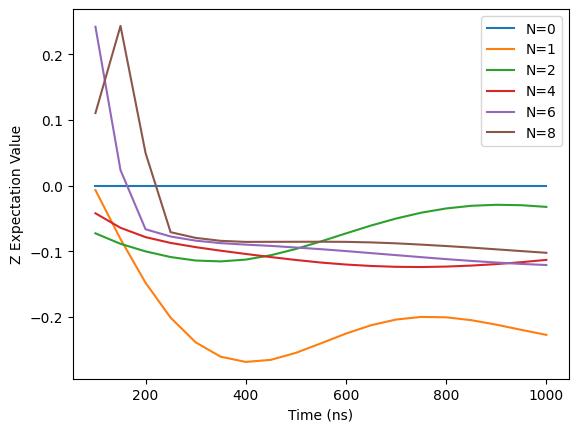

In [289]:
plt.plot(tau_list, z_tot_1[0], label = 'N=0')
plt.plot(tau_list, z_tot_1[1], label = 'N=1')
plt.plot(tau_list, z_tot_1[2], label = 'N=2')
plt.plot(tau_list, z_tot_1[3], label = 'N=4')
plt.plot(tau_list, z_tot_1[4], label = 'N=6')
plt.plot(tau_list, z_tot_1[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'Expectation Value')

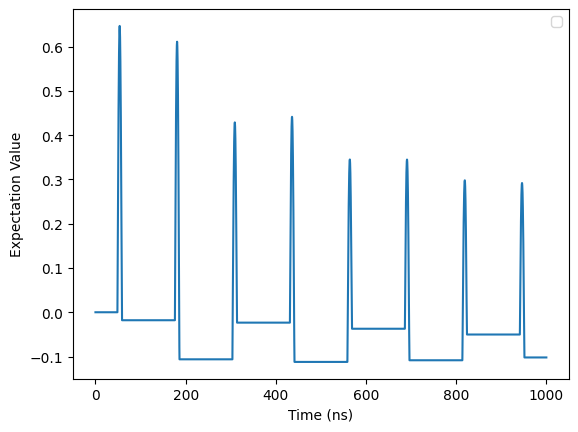

In [290]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0])
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Spectral Density')

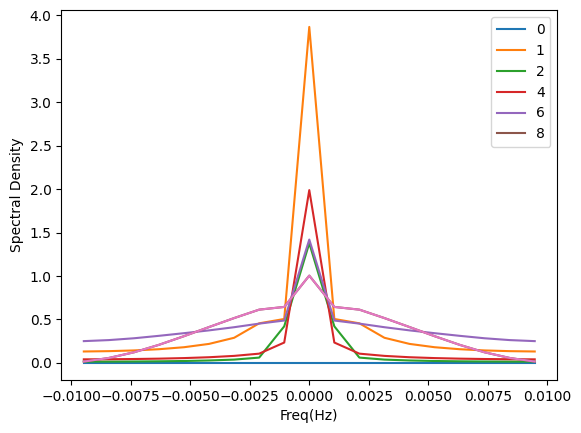

In [291]:
plt.figure()

for i in range(6):
  Gamma_fft = np.fft.fftshift(np.fft.fft(z_tot_1[i]))
  Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(z_tot_1[i]), d=tau_list[1]-tau_list[0]))
  plt.plot(Gamma_freq, np.abs(Gamma_fft), label="{0}".format(N_seq[i]))

plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.legend()
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

#### A = 0.006

In [185]:
z_tot_2 = []
plus_tot_2 = []

In [186]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz
kai = 2 * np.pi * 0.01

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[1]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [187]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[1], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_2.append(z)
  plus_tot_2.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

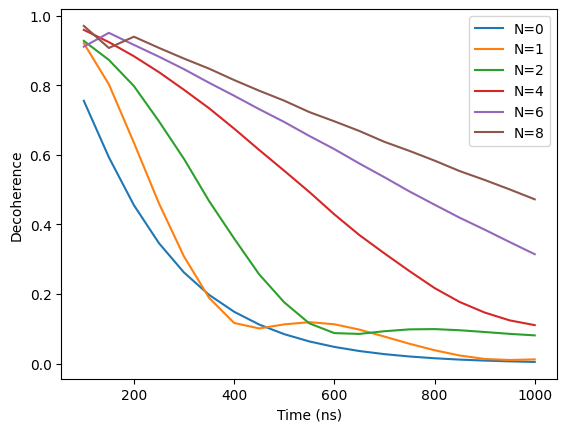

In [188]:
plt.plot(tau_list, plus_tot_2[0], label = 'N=0')
plt.plot(tau_list, plus_tot_2[1], label = 'N=1')
plt.plot(tau_list, plus_tot_2[2], label = 'N=2')
plt.plot(tau_list, plus_tot_2[3], label = 'N=4')
plt.plot(tau_list, plus_tot_2[4], label = 'N=6')
plt.plot(tau_list, plus_tot_2[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

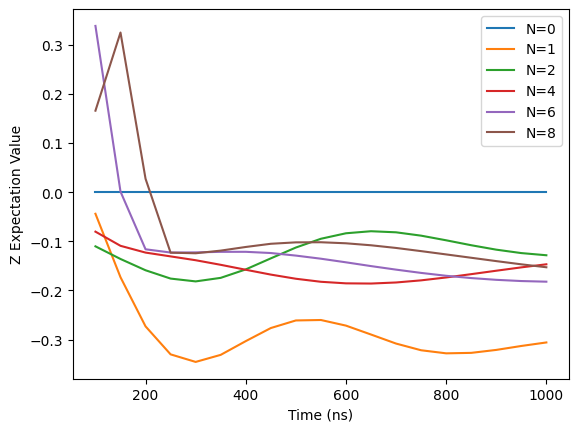

In [189]:
plt.plot(tau_list, z_tot_2[0], label = 'N=0')
plt.plot(tau_list, z_tot_2[1], label = 'N=1')
plt.plot(tau_list, z_tot_2[2], label = 'N=2')
plt.plot(tau_list, z_tot_2[3], label = 'N=4')
plt.plot(tau_list, z_tot_2[4], label = 'N=6')
plt.plot(tau_list, z_tot_2[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'Spectral Density')

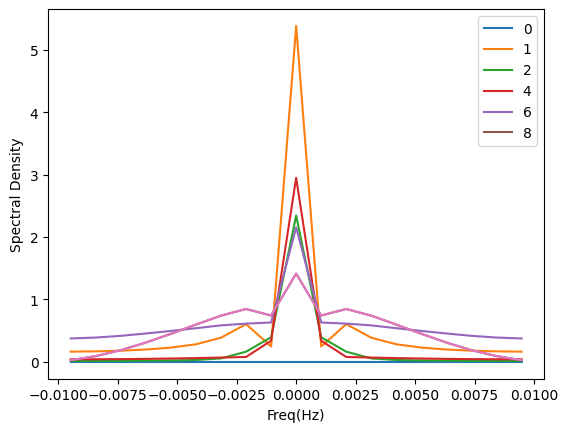

In [281]:
plt.figure()

for i in range(6):
  Gamma_fft = np.fft.fftshift(np.fft.fft(z_tot_2[i]))
  Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(z_tot_2[i]), d=tau_list[1]-tau_list[0]))
  plt.plot(Gamma_freq, np.abs(Gamma_fft), label="{0}".format(N_seq[i]))

plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.legend()
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

#### A = 0.007

In [190]:
z_tot_3 = []
plus_tot_3 = []

In [191]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz
kai = 2 * np.pi * 0.01

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[2]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [192]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[2], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_3.append(z)
  plus_tot_3.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

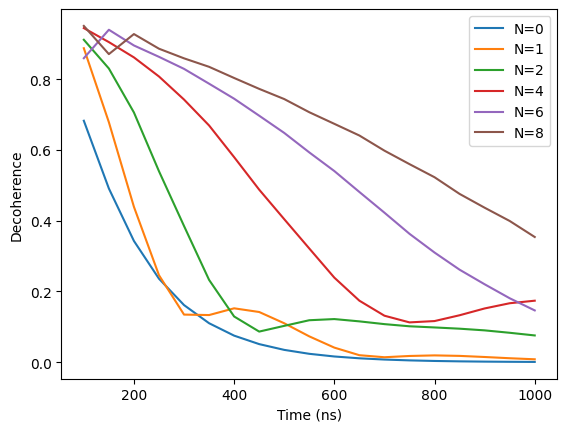

In [193]:
plt.plot(tau_list, plus_tot_3[0], label = 'N=0')
plt.plot(tau_list, plus_tot_3[1], label = 'N=1')
plt.plot(tau_list, plus_tot_3[2], label = 'N=2')
plt.plot(tau_list, plus_tot_3[3], label = 'N=4')
plt.plot(tau_list, plus_tot_3[4], label = 'N=6')
plt.plot(tau_list, plus_tot_3[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

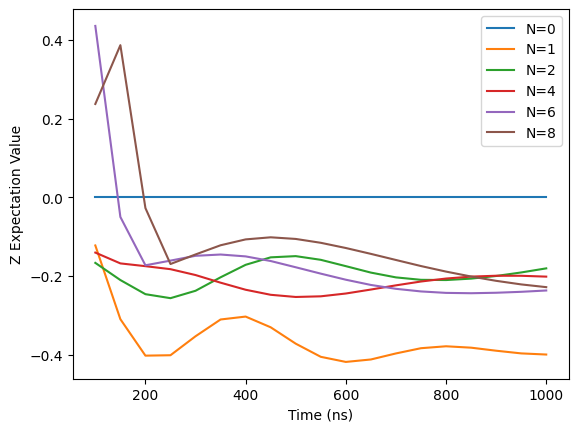

In [194]:
plt.plot(tau_list, z_tot_3[0], label = 'N=0')
plt.plot(tau_list, z_tot_3[1], label = 'N=1')
plt.plot(tau_list, z_tot_3[2], label = 'N=2')
plt.plot(tau_list, z_tot_3[3], label = 'N=4')
plt.plot(tau_list, z_tot_3[4], label = 'N=6')
plt.plot(tau_list, z_tot_3[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.008

In [200]:
z_tot_4 = []
plus_tot_4 = []

In [201]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[3]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [202]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[3], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_4.append(z)
  plus_tot_4.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

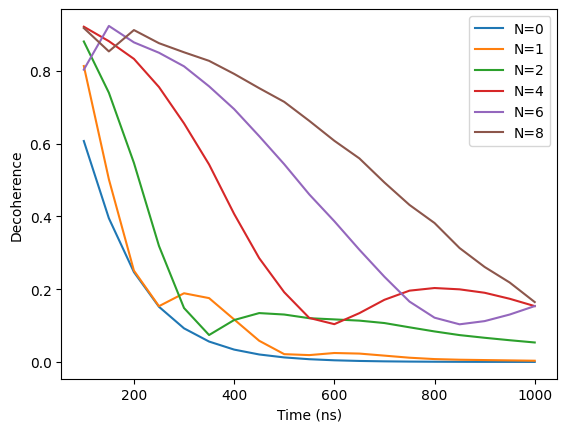

In [203]:
plt.plot(tau_list, plus_tot_4[0], label = 'N=0')
plt.plot(tau_list, plus_tot_4[1], label = 'N=1')
plt.plot(tau_list, plus_tot_4[2], label = 'N=2')
plt.plot(tau_list, plus_tot_4[3], label = 'N=4')
plt.plot(tau_list, plus_tot_4[4], label = 'N=6')
plt.plot(tau_list, plus_tot_4[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

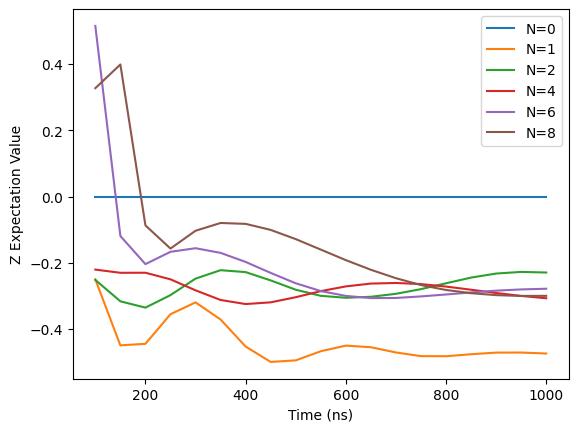

In [204]:
plt.plot(tau_list, z_tot_4[0], label = 'N=0')
plt.plot(tau_list, z_tot_4[1], label = 'N=1')
plt.plot(tau_list, z_tot_4[2], label = 'N=2')
plt.plot(tau_list, z_tot_4[3], label = 'N=4')
plt.plot(tau_list, z_tot_4[4], label = 'N=6')
plt.plot(tau_list, z_tot_4[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'Spectral Density')

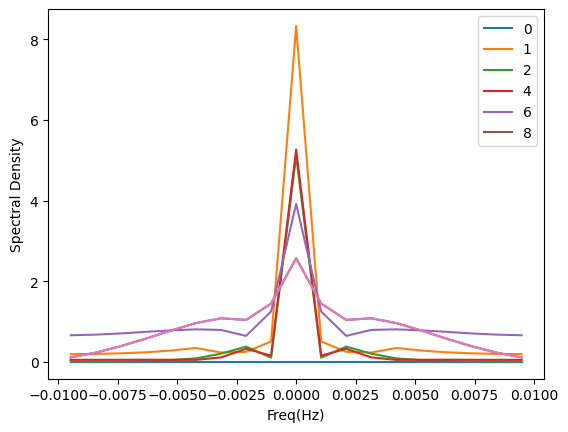

In [282]:
plt.figure()

for i in range(6):
  Gamma_fft = np.fft.fftshift(np.fft.fft(z_tot_4[i]))
  Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(z_tot_4[i]), d=tau_list[1]-tau_list[0]))
  plt.plot(Gamma_freq, np.abs(Gamma_fft), label="{0}".format(N_seq[i]))

plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.legend()
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

#### A = 0.009

In [256]:
z_tot_5 = []
plus_tot_5 = []

In [257]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[4]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [258]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[4], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_5.append(z)
  plus_tot_5.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

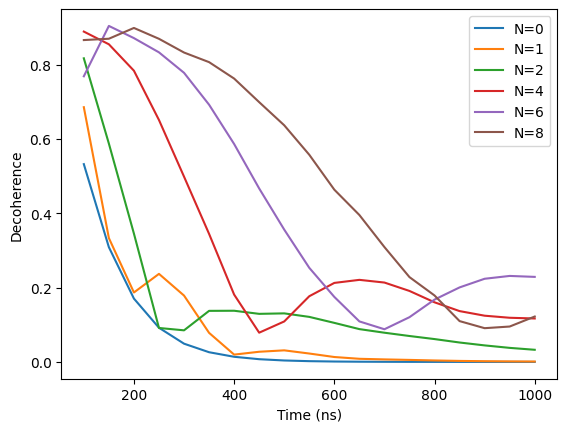

In [259]:
plt.plot(tau_list, plus_tot_5[0], label = 'N=0')
plt.plot(tau_list, plus_tot_5[1], label = 'N=1')
plt.plot(tau_list, plus_tot_5[2], label = 'N=2')
plt.plot(tau_list, plus_tot_5[3], label = 'N=4')
plt.plot(tau_list, plus_tot_5[4], label = 'N=6')
plt.plot(tau_list, plus_tot_5[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

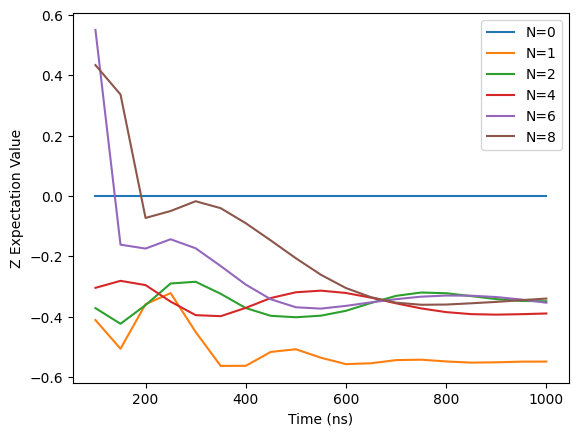

In [260]:
plt.plot(tau_list, z_tot_5[0], label = 'N=0')
plt.plot(tau_list, z_tot_5[1], label = 'N=1')
plt.plot(tau_list, z_tot_5[2], label = 'N=2')
plt.plot(tau_list, z_tot_5[3], label = 'N=4')
plt.plot(tau_list, z_tot_5[4], label = 'N=6')
plt.plot(tau_list, z_tot_5[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.010

In [210]:
z_tot_6 = []
plus_tot_6 = []

In [211]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[5]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [212]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[5], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_6.append(z)
  plus_tot_6.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

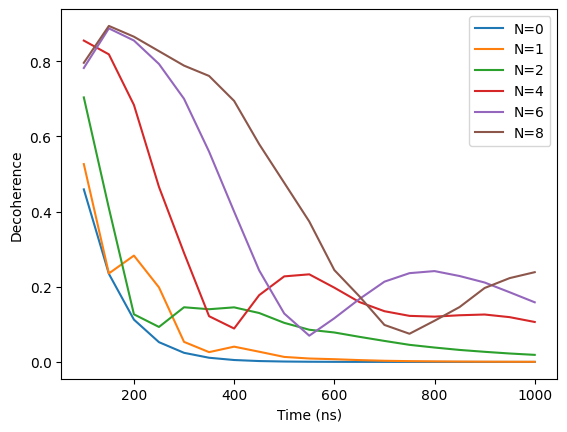

In [213]:
plt.plot(tau_list, plus_tot_6[0], label = 'N=0')
plt.plot(tau_list, plus_tot_6[1], label = 'N=1')
plt.plot(tau_list, plus_tot_6[2], label = 'N=2')
plt.plot(tau_list, plus_tot_6[3], label = 'N=4')
plt.plot(tau_list, plus_tot_6[4], label = 'N=6')
plt.plot(tau_list, plus_tot_6[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

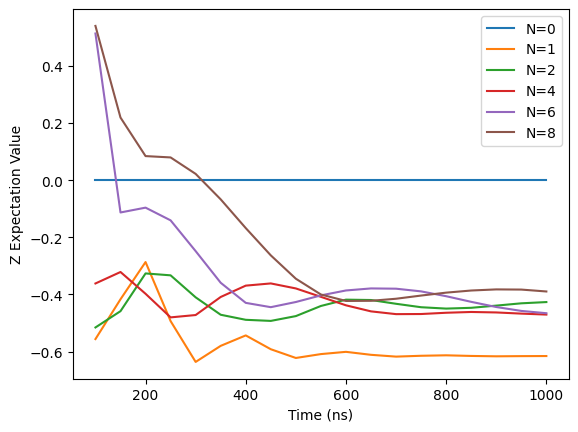

In [214]:
plt.plot(tau_list, z_tot_6[0], label = 'N=0')
plt.plot(tau_list, z_tot_6[1], label = 'N=1')
plt.plot(tau_list, z_tot_6[2], label = 'N=2')
plt.plot(tau_list, z_tot_6[3], label = 'N=4')
plt.plot(tau_list, z_tot_6[4], label = 'N=6')
plt.plot(tau_list, z_tot_6[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'Spectral Density')

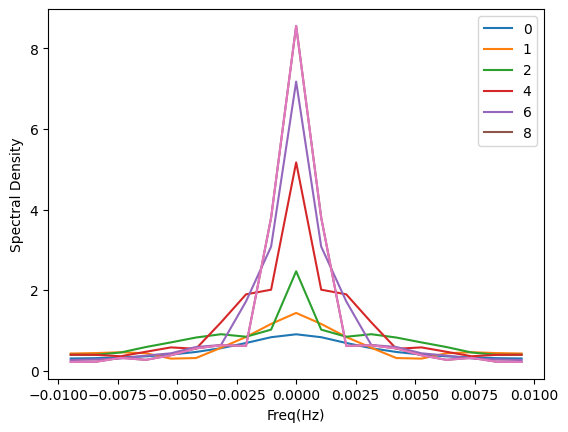

In [283]:
plt.figure()

for i in range(6):
  Gamma_fft = np.fft.fftshift(np.fft.fft(plus_tot_6[i]))
  Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_tot_6[i]), d=tau_list[1]-tau_list[0]))
  plt.plot(Gamma_freq, np.abs(Gamma_fft), label="{0}".format(N_seq[i]))

plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.legend()
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

#### A = 0.011

In [215]:
z_tot_7 = []
plus_tot_7 = []

In [216]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[6]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [217]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[6], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_7.append(z)
  plus_tot_7.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

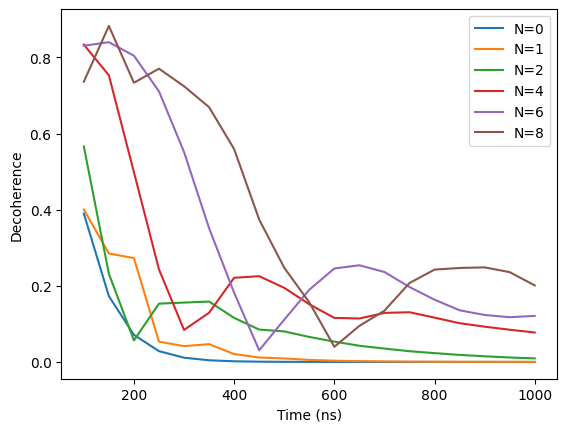

In [218]:
plt.plot(tau_list, plus_tot_7[0], label = 'N=0')
plt.plot(tau_list, plus_tot_7[1], label = 'N=1')
plt.plot(tau_list, plus_tot_7[2], label = 'N=2')
plt.plot(tau_list, plus_tot_7[3], label = 'N=4')
plt.plot(tau_list, plus_tot_7[4], label = 'N=6')
plt.plot(tau_list, plus_tot_7[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

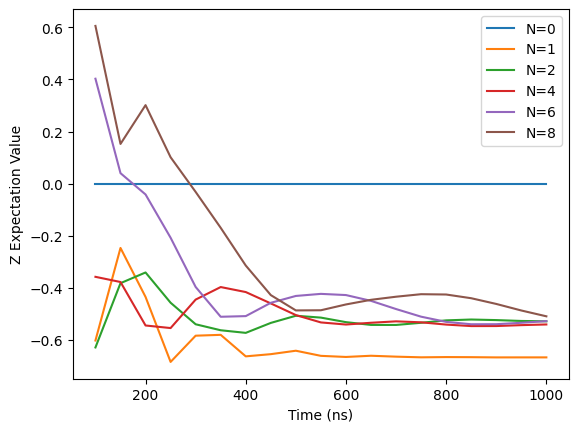

In [219]:
plt.plot(tau_list, z_tot_7[0], label = 'N=0')
plt.plot(tau_list, z_tot_7[1], label = 'N=1')
plt.plot(tau_list, z_tot_7[2], label = 'N=2')
plt.plot(tau_list, z_tot_7[3], label = 'N=4')
plt.plot(tau_list, z_tot_7[4], label = 'N=6')
plt.plot(tau_list, z_tot_7[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.012

In [220]:
z_tot_8 = []
plus_tot_8 = []

In [221]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[7]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [222]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[7], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_8.append(z)
  plus_tot_8.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

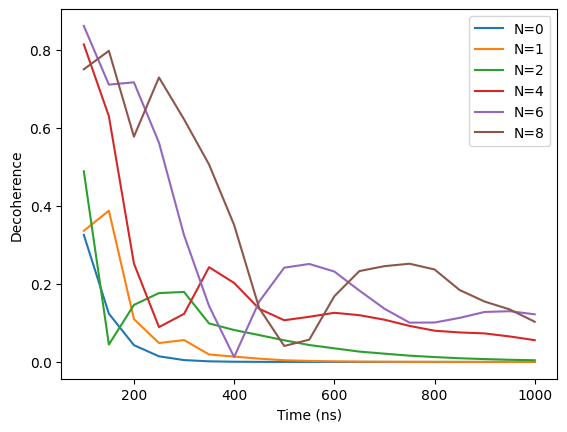

In [223]:
plt.plot(tau_list, plus_tot_8[0], label = 'N=0')
plt.plot(tau_list, plus_tot_8[1], label = 'N=1')
plt.plot(tau_list, plus_tot_8[2], label = 'N=2')
plt.plot(tau_list, plus_tot_8[3], label = 'N=4')
plt.plot(tau_list, plus_tot_8[4], label = 'N=6')
plt.plot(tau_list, plus_tot_8[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

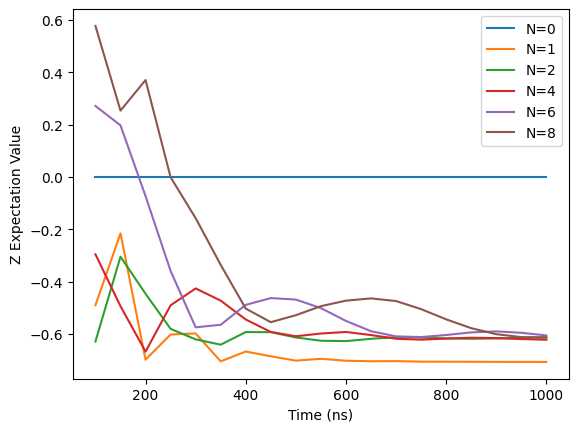

In [224]:
plt.plot(tau_list, z_tot_8[0], label = 'N=0')
plt.plot(tau_list, z_tot_8[1], label = 'N=1')
plt.plot(tau_list, z_tot_8[2], label = 'N=2')
plt.plot(tau_list, z_tot_8[3], label = 'N=4')
plt.plot(tau_list, z_tot_8[4], label = 'N=6')
plt.plot(tau_list, z_tot_8[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.013

In [225]:
z_tot_9 = []
plus_tot_9 = []

In [226]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[8]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [227]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[8], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_9.append(z)
  plus_tot_9.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

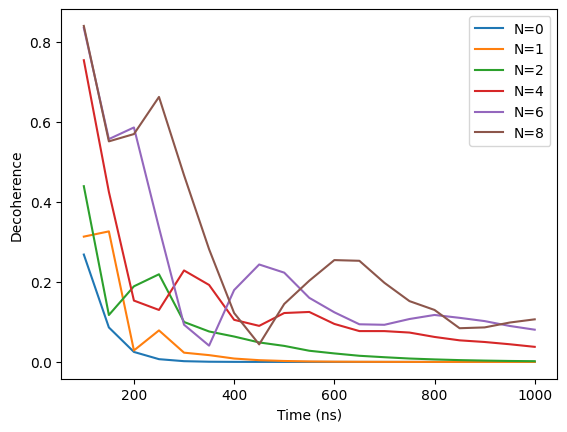

In [228]:
plt.plot(tau_list, plus_tot_9[0], label = 'N=0')
plt.plot(tau_list, plus_tot_9[1], label = 'N=1')
plt.plot(tau_list, plus_tot_9[2], label = 'N=2')
plt.plot(tau_list, plus_tot_9[3], label = 'N=4')
plt.plot(tau_list, plus_tot_9[4], label = 'N=6')
plt.plot(tau_list, plus_tot_9[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

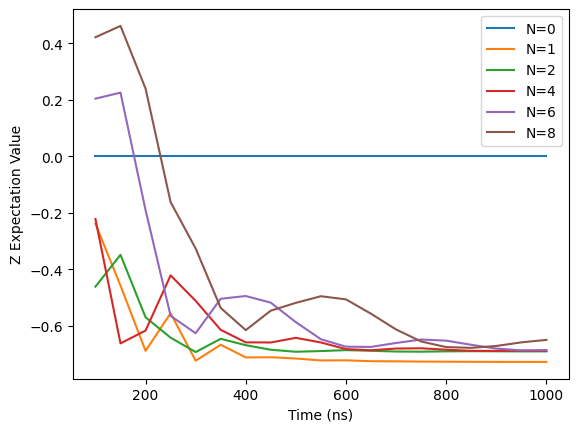

In [229]:
plt.plot(tau_list, z_tot_9[0], label = 'N=0')
plt.plot(tau_list, z_tot_9[1], label = 'N=1')
plt.plot(tau_list, z_tot_9[2], label = 'N=2')
plt.plot(tau_list, z_tot_9[3], label = 'N=4')
plt.plot(tau_list, z_tot_9[4], label = 'N=6')
plt.plot(tau_list, z_tot_9[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.014

In [230]:
z_tot_10 = []
plus_tot_10 = []

In [231]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.005   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[9]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [232]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[9], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_10.append(z)
  plus_tot_10.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

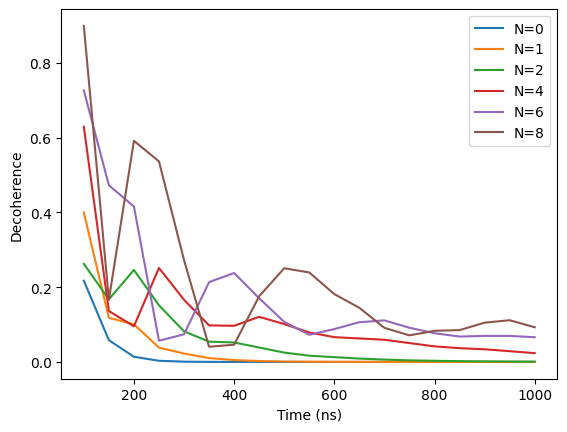

In [233]:
plt.plot(tau_list, plus_tot_10[0], label = 'N=0')
plt.plot(tau_list, plus_tot_10[1], label = 'N=1')
plt.plot(tau_list, plus_tot_10[2], label = 'N=2')
plt.plot(tau_list, plus_tot_10[3], label = 'N=4')
plt.plot(tau_list, plus_tot_10[4], label = 'N=6')
plt.plot(tau_list, plus_tot_10[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

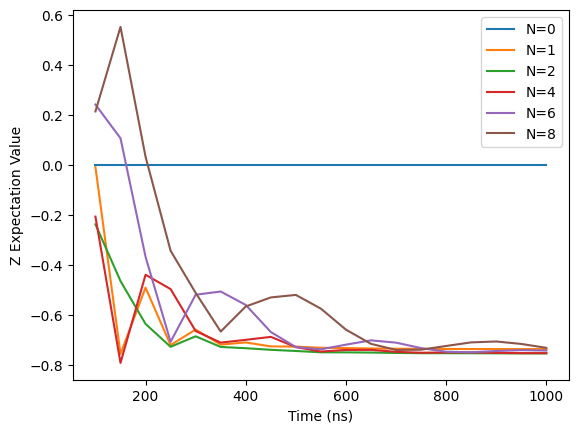

In [234]:
plt.plot(tau_list, z_tot_10[0], label = 'N=0')
plt.plot(tau_list, z_tot_10[1], label = 'N=1')
plt.plot(tau_list, z_tot_10[2], label = 'N=2')
plt.plot(tau_list, z_tot_10[3], label = 'N=4')
plt.plot(tau_list, z_tot_10[4], label = 'N=6')
plt.plot(tau_list, z_tot_10[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'Spectral Density')

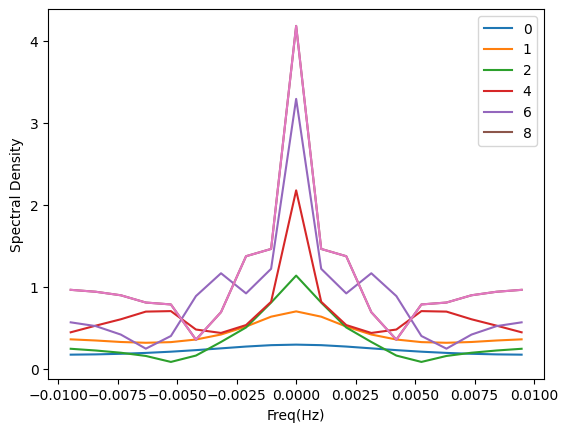

In [284]:
plt.figure()

for i in range(6):
  Gamma_fft = np.fft.fftshift(np.fft.fft(plus_tot_10[i]))
  Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(plus_tot_10[i]), d=tau_list[1]-tau_list[0]))
  plt.plot(Gamma_freq, np.abs(Gamma_fft), label="{0}".format(N_seq[i]))

plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.legend()
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

### 8) Off Diagonal Term Evolution B=0.05GHz with Brain

Initial State $\frac{|0\rangle+|1\rangle}{\sqrt{2}}$

kappa = 0.01 GHz

Result :


In [292]:
A =     [0.0025, 0.003, 0.0035, 0.004, 0.0045, 0.005, 0.0055, 0.006, 0.0065, 0.007]
n_exp = [0.125, 0.180, 0.245, 0.320, 0.405, 0.500, 0.605, 0.720, 0.845, 0.978]
N_seq = [0,1,2,4,6,8]
tau_list = [50*(k+2) for k in range(19)]

#### A = 0.005

In [293]:
z_tot_1 = []
plus_tot_1 = []

In [294]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz
kai = 2 * np.pi * 0.01

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = +kai*n_exp[0]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [295]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[0], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_1.append(z)
  plus_tot_1.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

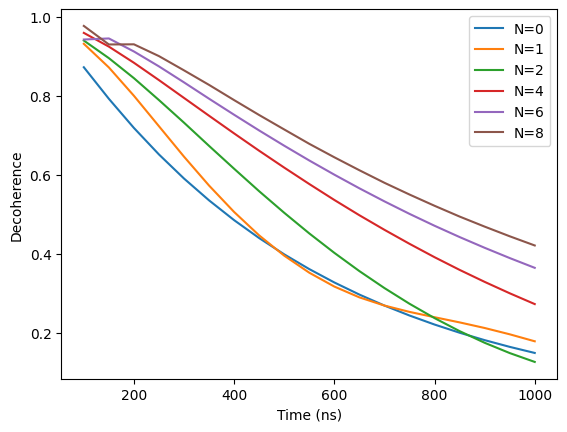

In [296]:
plt.plot(tau_list, plus_tot_1[0], label = 'N=0')
plt.plot(tau_list, plus_tot_1[1], label = 'N=1')
plt.plot(tau_list, plus_tot_1[2], label = 'N=2')
plt.plot(tau_list, plus_tot_1[3], label = 'N=4')
plt.plot(tau_list, plus_tot_1[4], label = 'N=6')
plt.plot(tau_list, plus_tot_1[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

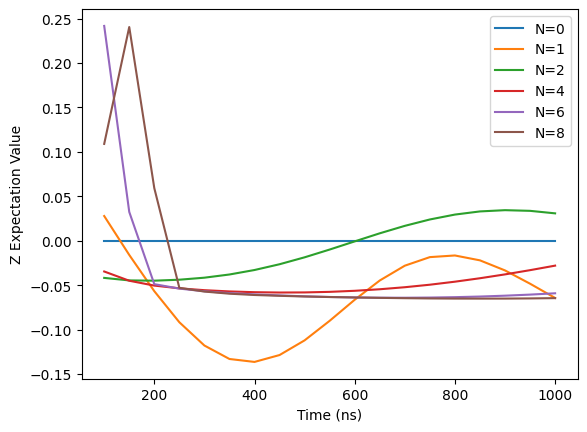

In [297]:
plt.plot(tau_list, z_tot_1[0], label = 'N=0')
plt.plot(tau_list, z_tot_1[1], label = 'N=1')
plt.plot(tau_list, z_tot_1[2], label = 'N=2')
plt.plot(tau_list, z_tot_1[3], label = 'N=4')
plt.plot(tau_list, z_tot_1[4], label = 'N=6')
plt.plot(tau_list, z_tot_1[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'Expectation Value')

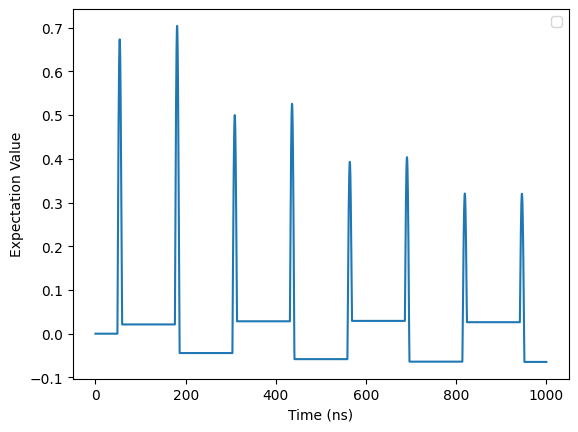

In [298]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0])
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')

Text(0, 0.5, 'Spectral Density')

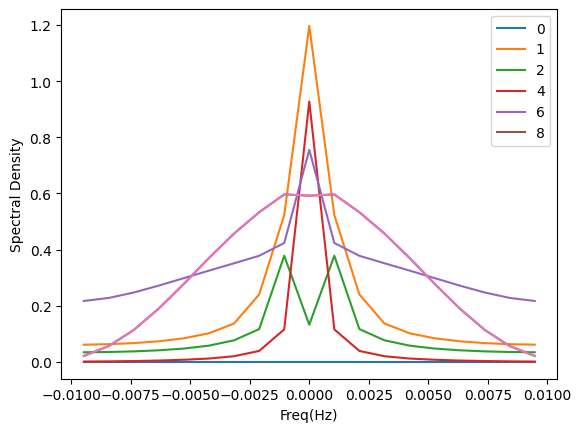

In [299]:
plt.figure()

for i in range(6):
  Gamma_fft = np.fft.fftshift(np.fft.fft(z_tot_1[i]))
  Gamma_freq = np.fft.fftshift(np.fft.fftfreq(len(z_tot_1[i]), d=tau_list[1]-tau_list[0]))
  plt.plot(Gamma_freq, np.abs(Gamma_fft), label="{0}".format(N_seq[i]))

plt.plot(Gamma_freq, np.abs(Gamma_fft))
plt.legend()
plt.xlabel('Freq(Hz)')
plt.ylabel('Spectral Density')

#### A = 0.006

In [300]:
z_tot_2 = []
plus_tot_2 = []

In [301]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz
kai = 2 * np.pi * 0.01

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[1]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [302]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[1], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_2.append(z)
  plus_tot_2.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

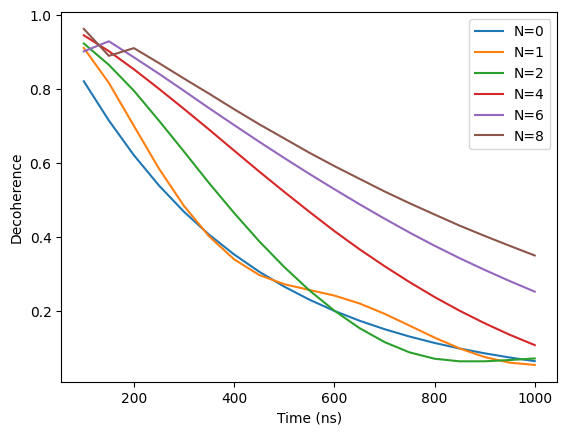

In [303]:
plt.plot(tau_list, plus_tot_2[0], label = 'N=0')
plt.plot(tau_list, plus_tot_2[1], label = 'N=1')
plt.plot(tau_list, plus_tot_2[2], label = 'N=2')
plt.plot(tau_list, plus_tot_2[3], label = 'N=4')
plt.plot(tau_list, plus_tot_2[4], label = 'N=6')
plt.plot(tau_list, plus_tot_2[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

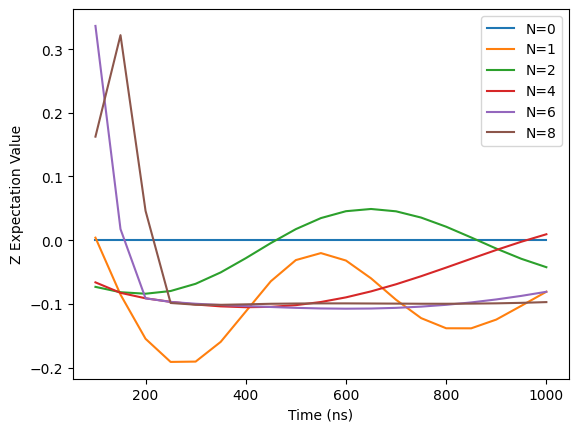

In [304]:
plt.plot(tau_list, z_tot_2[0], label = 'N=0')
plt.plot(tau_list, z_tot_2[1], label = 'N=1')
plt.plot(tau_list, z_tot_2[2], label = 'N=2')
plt.plot(tau_list, z_tot_2[3], label = 'N=4')
plt.plot(tau_list, z_tot_2[4], label = 'N=6')
plt.plot(tau_list, z_tot_2[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.007

In [305]:
z_tot_3 = []
plus_tot_3 = []

In [306]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz
kai = 2 * np.pi * 0.01

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[2]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [307]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[2], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_3.append(z)
  plus_tot_3.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

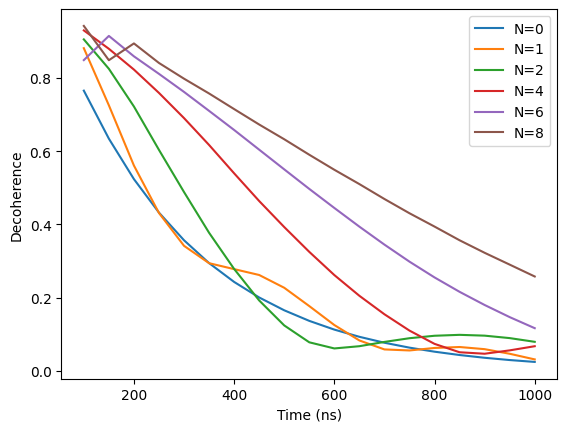

In [308]:
plt.plot(tau_list, plus_tot_3[0], label = 'N=0')
plt.plot(tau_list, plus_tot_3[1], label = 'N=1')
plt.plot(tau_list, plus_tot_3[2], label = 'N=2')
plt.plot(tau_list, plus_tot_3[3], label = 'N=4')
plt.plot(tau_list, plus_tot_3[4], label = 'N=6')
plt.plot(tau_list, plus_tot_3[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

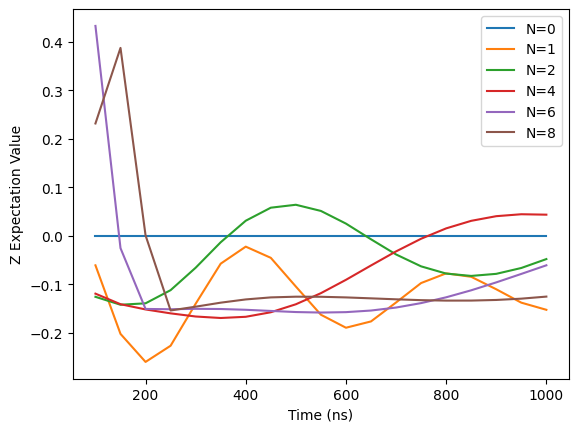

In [309]:
plt.plot(tau_list, z_tot_3[0], label = 'N=0')
plt.plot(tau_list, z_tot_3[1], label = 'N=1')
plt.plot(tau_list, z_tot_3[2], label = 'N=2')
plt.plot(tau_list, z_tot_3[3], label = 'N=4')
plt.plot(tau_list, z_tot_3[4], label = 'N=6')
plt.plot(tau_list, z_tot_3[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.008

In [310]:
z_tot_4 = []
plus_tot_4 = []

In [311]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[3]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [312]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[3], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_4.append(z)
  plus_tot_4.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

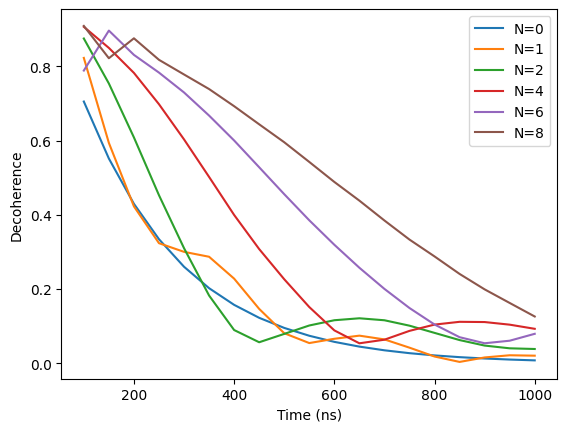

In [313]:
plt.plot(tau_list, plus_tot_4[0], label = 'N=0')
plt.plot(tau_list, plus_tot_4[1], label = 'N=1')
plt.plot(tau_list, plus_tot_4[2], label = 'N=2')
plt.plot(tau_list, plus_tot_4[3], label = 'N=4')
plt.plot(tau_list, plus_tot_4[4], label = 'N=6')
plt.plot(tau_list, plus_tot_4[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

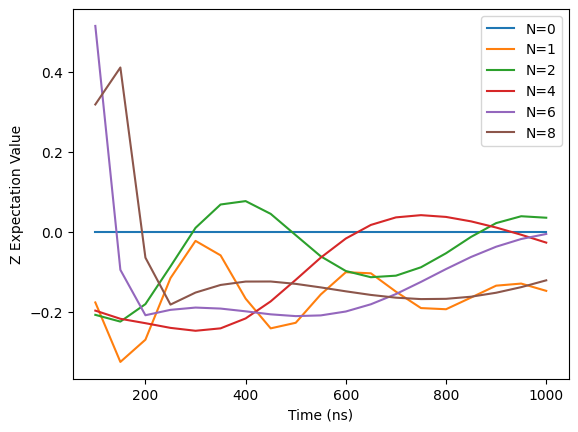

In [314]:
plt.plot(tau_list, z_tot_4[0], label = 'N=0')
plt.plot(tau_list, z_tot_4[1], label = 'N=1')
plt.plot(tau_list, z_tot_4[2], label = 'N=2')
plt.plot(tau_list, z_tot_4[3], label = 'N=4')
plt.plot(tau_list, z_tot_4[4], label = 'N=6')
plt.plot(tau_list, z_tot_4[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.009

In [315]:
z_tot_5 = []
plus_tot_5 = []

In [316]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[4]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [317]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[4], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_5.append(z)
  plus_tot_5.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

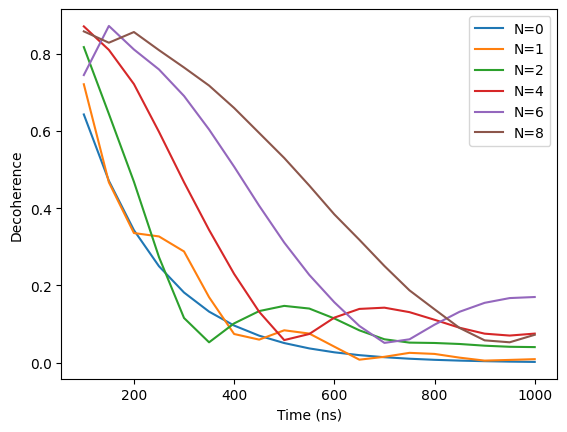

In [318]:
plt.plot(tau_list, plus_tot_5[0], label = 'N=0')
plt.plot(tau_list, plus_tot_5[1], label = 'N=1')
plt.plot(tau_list, plus_tot_5[2], label = 'N=2')
plt.plot(tau_list, plus_tot_5[3], label = 'N=4')
plt.plot(tau_list, plus_tot_5[4], label = 'N=6')
plt.plot(tau_list, plus_tot_5[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

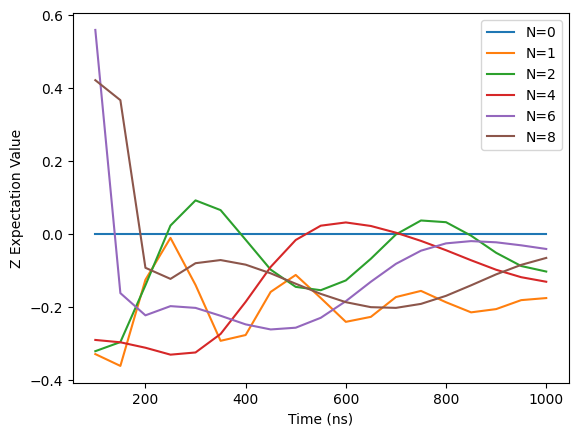

In [319]:
plt.plot(tau_list, z_tot_5[0], label = 'N=0')
plt.plot(tau_list, z_tot_5[1], label = 'N=1')
plt.plot(tau_list, z_tot_5[2], label = 'N=2')
plt.plot(tau_list, z_tot_5[3], label = 'N=4')
plt.plot(tau_list, z_tot_5[4], label = 'N=6')
plt.plot(tau_list, z_tot_5[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.010

In [320]:
z_tot_6 = []
plus_tot_6 = []

In [321]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[5]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [322]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[5], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_6.append(z)
  plus_tot_6.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

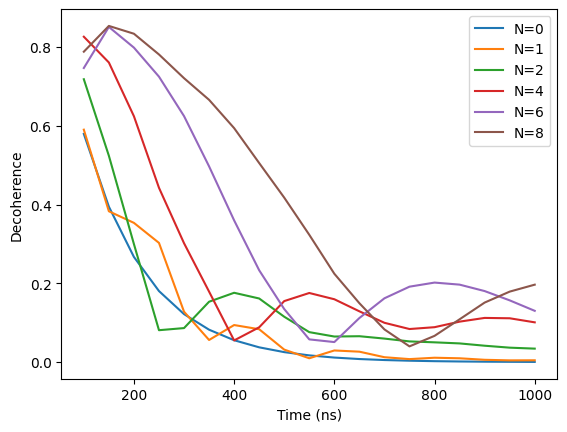

In [323]:
plt.plot(tau_list, plus_tot_6[0], label = 'N=0')
plt.plot(tau_list, plus_tot_6[1], label = 'N=1')
plt.plot(tau_list, plus_tot_6[2], label = 'N=2')
plt.plot(tau_list, plus_tot_6[3], label = 'N=4')
plt.plot(tau_list, plus_tot_6[4], label = 'N=6')
plt.plot(tau_list, plus_tot_6[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

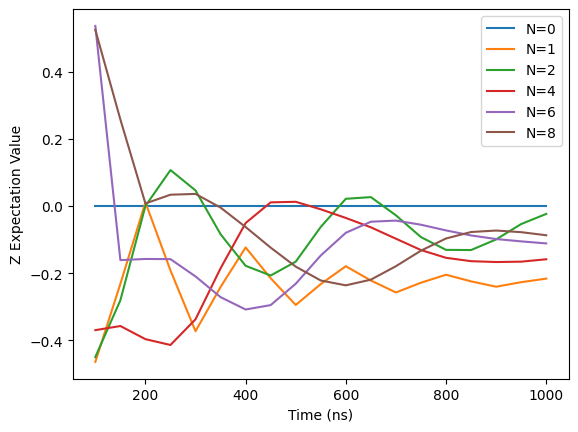

In [324]:
plt.plot(tau_list, z_tot_6[0], label = 'N=0')
plt.plot(tau_list, z_tot_6[1], label = 'N=1')
plt.plot(tau_list, z_tot_6[2], label = 'N=2')
plt.plot(tau_list, z_tot_6[3], label = 'N=4')
plt.plot(tau_list, z_tot_6[4], label = 'N=6')
plt.plot(tau_list, z_tot_6[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.011

In [325]:
z_tot_7 = []
plus_tot_7 = []

In [326]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[6]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [327]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[6], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_7.append(z)
  plus_tot_7.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

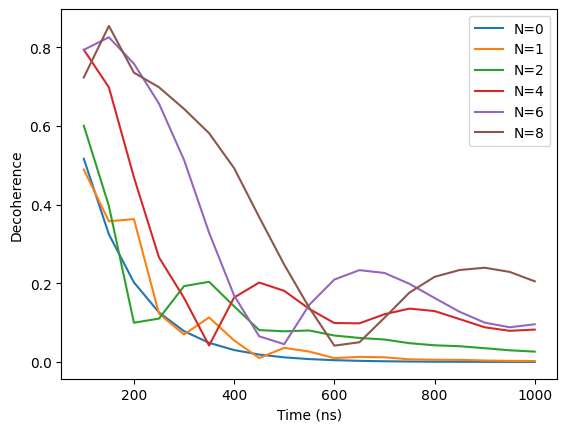

In [328]:
plt.plot(tau_list, plus_tot_7[0], label = 'N=0')
plt.plot(tau_list, plus_tot_7[1], label = 'N=1')
plt.plot(tau_list, plus_tot_7[2], label = 'N=2')
plt.plot(tau_list, plus_tot_7[3], label = 'N=4')
plt.plot(tau_list, plus_tot_7[4], label = 'N=6')
plt.plot(tau_list, plus_tot_7[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

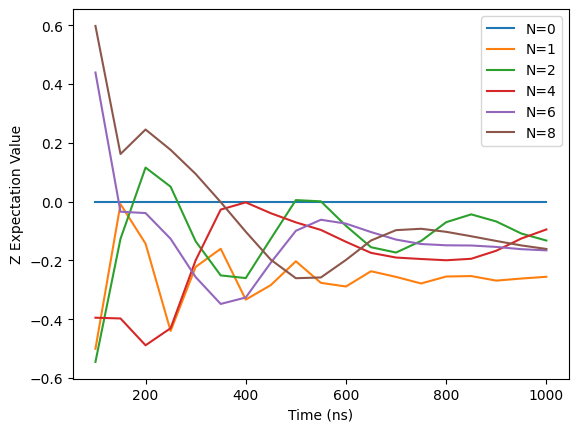

In [329]:
plt.plot(tau_list, z_tot_7[0], label = 'N=0')
plt.plot(tau_list, z_tot_7[1], label = 'N=1')
plt.plot(tau_list, z_tot_7[2], label = 'N=2')
plt.plot(tau_list, z_tot_7[3], label = 'N=4')
plt.plot(tau_list, z_tot_7[4], label = 'N=6')
plt.plot(tau_list, z_tot_7[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.012

In [330]:
z_tot_8 = []
plus_tot_8 = []

In [331]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[7]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [332]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[7], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_8.append(z)
  plus_tot_8.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

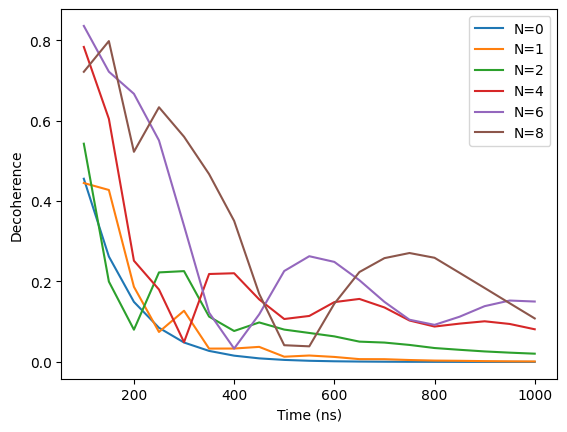

In [333]:
plt.plot(tau_list, plus_tot_8[0], label = 'N=0')
plt.plot(tau_list, plus_tot_8[1], label = 'N=1')
plt.plot(tau_list, plus_tot_8[2], label = 'N=2')
plt.plot(tau_list, plus_tot_8[3], label = 'N=4')
plt.plot(tau_list, plus_tot_8[4], label = 'N=6')
plt.plot(tau_list, plus_tot_8[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

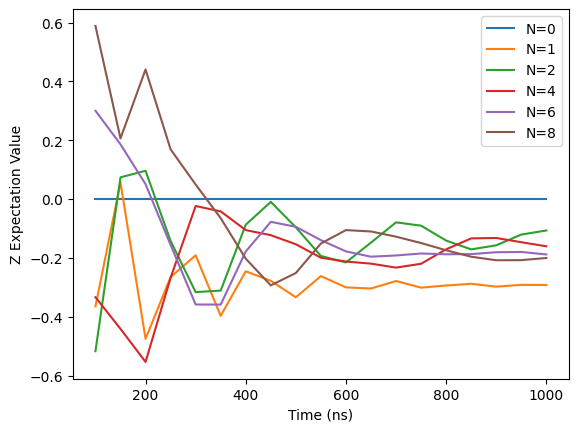

In [334]:
plt.plot(tau_list, z_tot_8[0], label = 'N=0')
plt.plot(tau_list, z_tot_8[1], label = 'N=1')
plt.plot(tau_list, z_tot_8[2], label = 'N=2')
plt.plot(tau_list, z_tot_8[3], label = 'N=4')
plt.plot(tau_list, z_tot_8[4], label = 'N=6')
plt.plot(tau_list, z_tot_8[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.013

In [335]:
z_tot_9 = []
plus_tot_9 = []

In [336]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[8]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [337]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[8], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_9.append(z)
  plus_tot_9.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

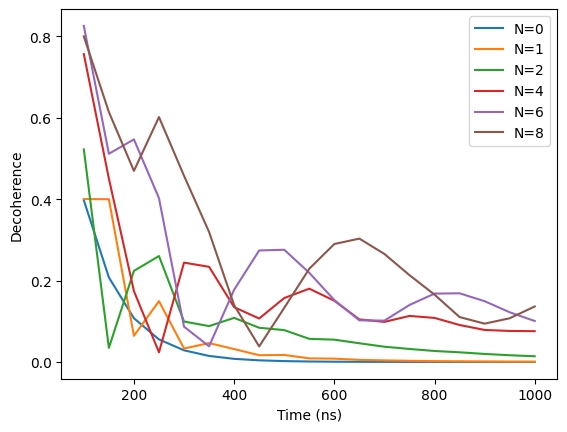

In [338]:
plt.plot(tau_list, plus_tot_9[0], label = 'N=0')
plt.plot(tau_list, plus_tot_9[1], label = 'N=1')
plt.plot(tau_list, plus_tot_9[2], label = 'N=2')
plt.plot(tau_list, plus_tot_9[3], label = 'N=4')
plt.plot(tau_list, plus_tot_9[4], label = 'N=6')
plt.plot(tau_list, plus_tot_9[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

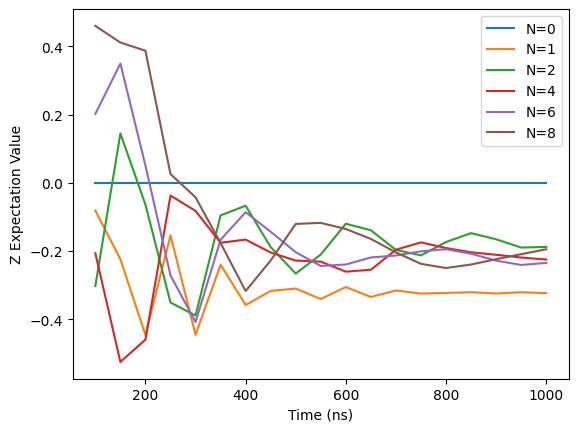

In [339]:
plt.plot(tau_list, z_tot_9[0], label = 'N=0')
plt.plot(tau_list, z_tot_9[1], label = 'N=1')
plt.plot(tau_list, z_tot_9[2], label = 'N=2')
plt.plot(tau_list, z_tot_9[3], label = 'N=4')
plt.plot(tau_list, z_tot_9[4], label = 'N=6')
plt.plot(tau_list, z_tot_9[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

#### A = 0.014

In [340]:
z_tot_10 = []
plus_tot_10 = []

In [341]:
N = 10

omega_r = 2 * np.pi * 7.0  # resonator frequency in units of GHz
omega_q = 2 * np.pi * 6.0  # qubit frequency in units of GHz
omega_rd = 2 * np.pi * 6.9  # qubit frequency in units of GHz
g = 2 * np.pi * 0.1        # qubit-resonator coupling in units of GHz
kappa = 2 * np.pi * 0.01   # external coupling rate of resonator in units of GHz

sz = sigmaz()
sx = sigmax()
sy = sigmay()
sp = basis(2,1)*basis(2,0).dag()
a = destroy(N)

sx_composite = tensor(sx, qeye(N))
sy_composite = tensor(sy, qeye(N))
sz_composite = tensor(sz, qeye(N))
sp_composite = tensor(sp, qeye(N))
annihilate_composite = tensor(qeye(2), a)
number_composite = tensor(qeye(2), a.dag()*a)

op_list = [sz_composite, sp_composite]

psi_20 = tensor(basis(2,0), basis(N,0))
psi_2s = tensor((basis(2,0) + basis(2,1))/np.sqrt(2), basis(N,0))
psi_21 = tensor(basis(2,1), basis(N,0))

H0 = kai*n_exp[9]*sz_composite + (omega_r-omega_rd)*number_composite + g*tensor(sz, a.dag()*a)
H1 = 0.5*tensor(qeye(2), a + a.dag())
H2 = 0.5*sx_composite

In [342]:
for j in range(6):

  z = []
  plus = []

  for k in range(19):

    # Simulation
    tlist = np.linspace(0, 50*(k+2), 500*(k+2))

    result = mesolve(
      [H0, [H1, Hrd_rotating_frame], [H2, Hqd_rotating_frame]],
      psi_2s,
      tlist,
      c_ops = [np.sqrt(kappa) * tensor(qeye(2), a)],
      args = {'B': 2*np.pi*0.05, 'T_srt': -10, 'T_end': 50*(k+2)+10, 'N_seq': N_seq[j], 'Env': 0, 'Func': 0, 'A': 2*np.pi*A[9], 'T': 1500},
      e_ops = op_list,
      options = Options(nsteps = 5000*(k+2), atol = 1e-10, rtol = 1e-8)
    )

    z_sub = result.expect[0]
    plus_sub = result.expect[1]

    z.append(z_sub[-1])
    plus.append(np.abs(2*plus_sub[-1]))

  z_tot_10.append(z)
  plus_tot_10.append(plus)

  print(j)

0
1
2
3
4
5


Text(0, 0.5, 'Decoherence')

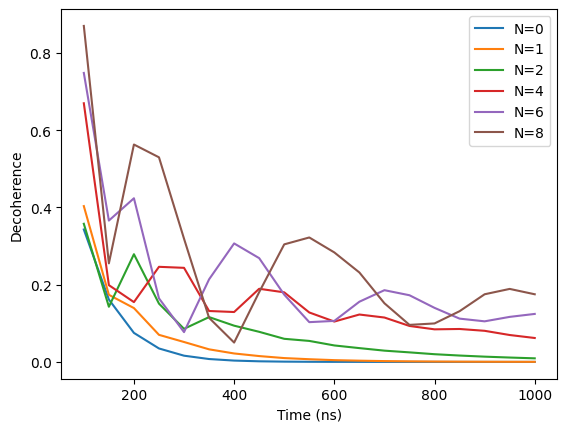

In [343]:
plt.plot(tau_list, plus_tot_10[0], label = 'N=0')
plt.plot(tau_list, plus_tot_10[1], label = 'N=1')
plt.plot(tau_list, plus_tot_10[2], label = 'N=2')
plt.plot(tau_list, plus_tot_10[3], label = 'N=4')
plt.plot(tau_list, plus_tot_10[4], label = 'N=6')
plt.plot(tau_list, plus_tot_10[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Decoherence')

Text(0, 0.5, 'Z Expectation Value')

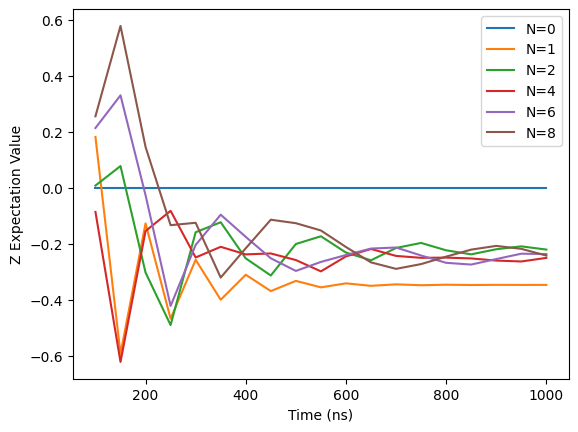

In [344]:
plt.plot(tau_list, z_tot_10[0], label = 'N=0')
plt.plot(tau_list, z_tot_10[1], label = 'N=1')
plt.plot(tau_list, z_tot_10[2], label = 'N=2')
plt.plot(tau_list, z_tot_10[3], label = 'N=4')
plt.plot(tau_list, z_tot_10[4], label = 'N=6')
plt.plot(tau_list, z_tot_10[5], label = 'N=8')
plt.legend(loc = 0)
plt.xlabel('Time (ns)')
plt.ylabel('Z Expectation Value')

Text(0, 0.5, 'Expectation Value')

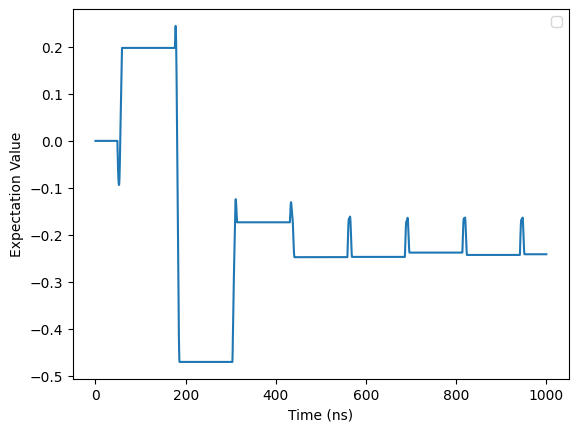

In [345]:
# Plot Z

fig, ax = plt.subplots(1, 1)
ax.plot(tlist, result.expect[0])
ax.legend(loc = 0)
ax.set_xlabel('Time (ns)')
ax.set_ylabel('Expectation Value')